# Data Loading

In [1]:
from datetime import datetime as dt
from fredapi import Fred
from data_utils import data_loader as dl

import pandas as pd
import numpy as np
from base_gpr_copy import Base_GP_Model
import torch


col_map = {
    'quote_date': 'quote_date',
    'expiration': 'expiration',
    'option_type': 'option_type',
    'strike': 'strike',
    'bid': 'bid_1545',
    'ask': 'ask_1545',
    'bid_size': 'bid_size_1545',
    'ask_size': 'ask_size_1545',
    'iv_source': 'implied_volatility_1545',
    'S_0': 'active_underlying_price_1545',
    'volume': 'trade_volume',
    'open': 'open',
    'high': 'high',
    'low': 'low',
    'close': 'close',
    'open_interest': 'open_interest'
}

# FRED Client
fred_client = Fred(api_key='fac7604001fe45ef764f2d068238b855')
# Select quote datetime.
quote_date = dt(2024, 2, 20, 15, 45)


quote_Data = dl.get_quote_date_data(quote_date,
					column_mapping=col_map,
					dividend_type='q_quote',
					fred_client=fred_client)
quote_Data.sort_values(by=['m', 'T'], inplace=True)

maturities = quote_Data['expiration'].unique()


In [2]:
maturityData = quote_Data[quote_Data['expiration'] == maturities[10]]
maturityData = maturityData[maturityData['m'] > -0.5]

In [3]:
maturityData.loc[:,'adj_bid_TIV'] = maturityData['union_bid_TIV']
maturityData.loc[:,'adj_ask_TIV'] = maturityData['union_ask_TIV']
maturityData.loc[:,'adj_mid_TIV'] = maturityData['union_mid_TIV']
maturityData = maturityData[maturityData['option_type']== 'C']

# Constrained GP Application

In [1]:
import pandas as pd
import numpy as np
from base_gpr_copy import Base_GP_Model
import torch

quoteDateData = pd.read_csv('quoteDateData.csv', index_col= False)
quoteDateData.sort_values(by=['m', 'T'], inplace=True)
quoteDateData['spread_IV'] = (quoteDateData['adj_ask_IV'] - quoteDateData['adj_bid_IV'])
quoteDateData['spread_TIV'] = (quoteDateData['adj_ask_TIV'] - quoteDateData['adj_bid_TIV'])

maturities = quoteDateData['expiration'].unique()
strikes = quoteDateData['strike'].unique()

In [4]:
#maturityData = quoteDateData[quoteDateData['expiration'] == maturities[10]]

y_label = 'TIV'
Smile_TIV = Base_GP_Model(
    device=torch.device('cpu'),
    quoteDateData= maturityData, 
	y_label = y_label, 
	type = 'smile',
	learn_additional_noise = True, 
	y_scaling_factor = 10,
	c = 0.01, sep_obs = False,
	train_fraction = 0.95, 
	lr = 0.05, training_iterations = 10000                    
)

Using device: cpu


Iter 2500/10000 - Loss: -1.6288
  lengthscale: tensor([[0.6931]], grad_fn=<SoftplusBackward0>)
  outputscale: 0.2219
Learning rates: [0.5, 0.05, 0.05, 0.05]
Iter 5000/10000 - Loss: -1.6302
  lengthscale: tensor([[0.6931]], grad_fn=<SoftplusBackward0>)
  outputscale: 0.2256
Learning rates: [0.5, 0.05, 0.05, 0.05]
Iter 7500/10000 - Loss: -1.6299
  lengthscale: tensor([[0.6931]], grad_fn=<SoftplusBackward0>)
  outputscale: 0.2264
Learning rates: [0.5, 0.05, 0.05, 0.05]
Iter 10000/10000 - Loss: -1.6307
  lengthscale: tensor([[0.6931]], grad_fn=<SoftplusBackward0>)
  outputscale: 0.2216
Learning rates: [0.5, 0.05, 0.05, 0.05]


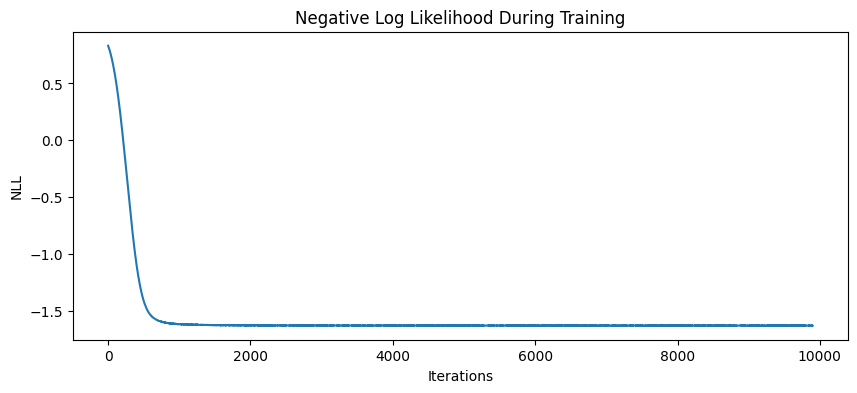

In [5]:
Smile_TIV.learn()

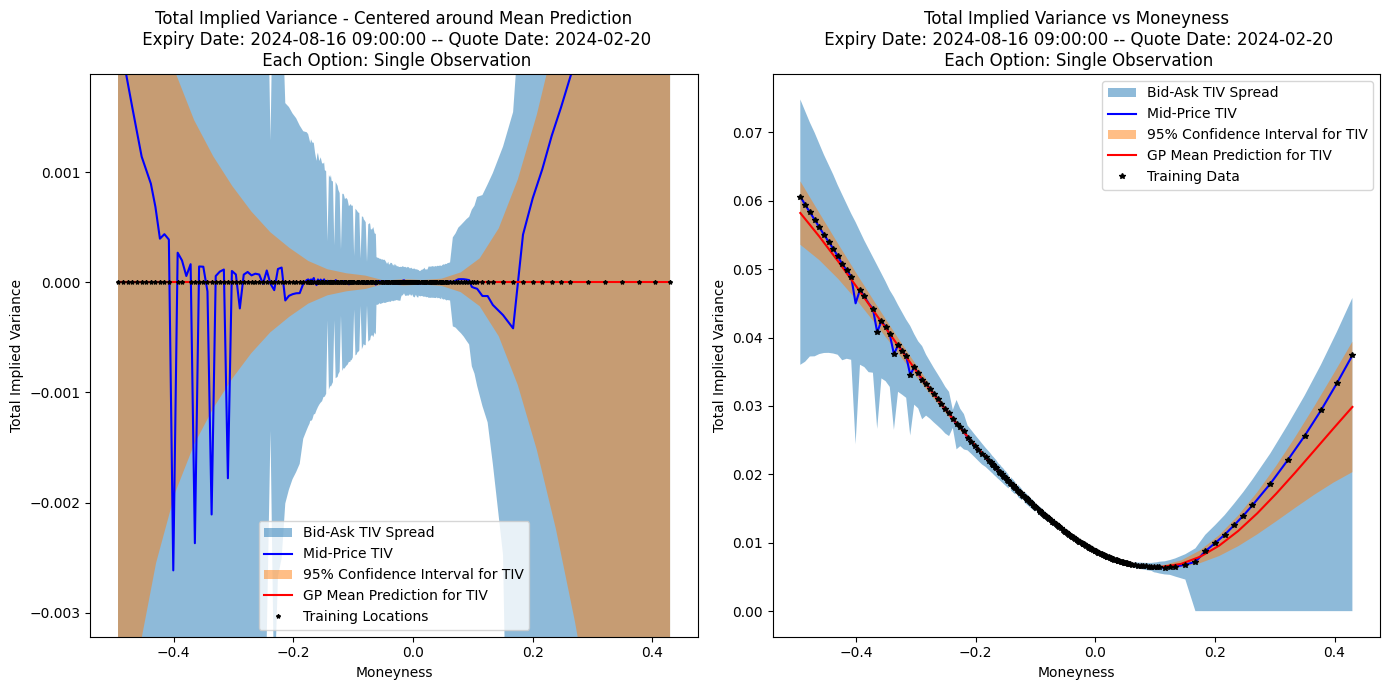

In [9]:
m = 30
delta_m = 1 / m

m_test_extra = np.linspace(0, 1, m)
Smile_TIV.predict(add_x_test= m_test_extra, add_label = 'extra')
Smile_TIV.plot_smile_comparison(figsize=(14, 7), zoom=10)

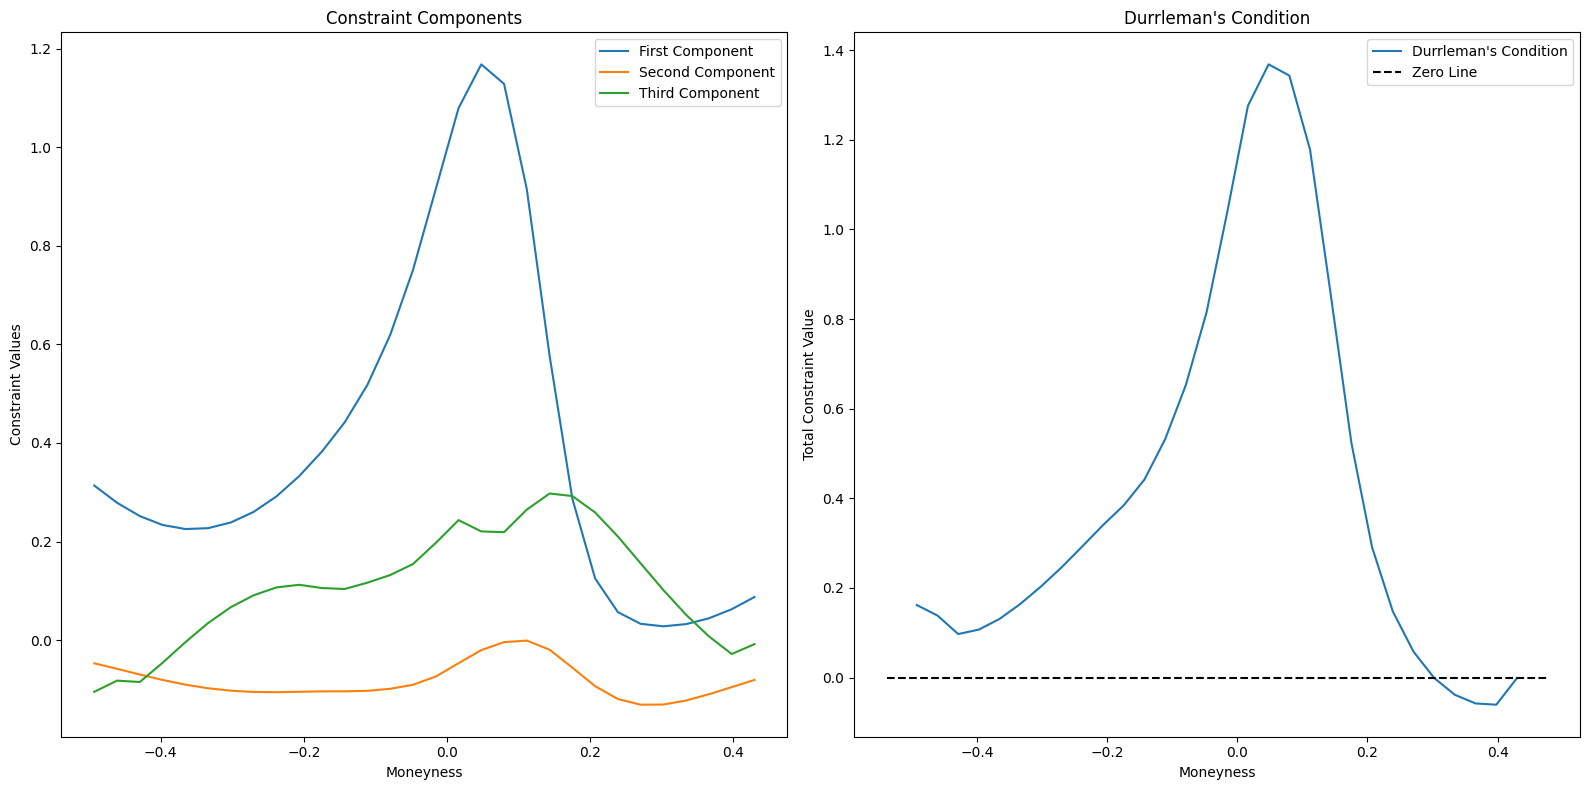

In [10]:
Smile_TIV.get_analytical_gradient(
    m_test_extra
).plot_constraint()

# Calculation of the constraints

Note that, we apply the following transformation to our input dimensions.

\begin{equation} \nonumber
\tilde{m} = \frac{m - m_{\min}}{m_{\max} - m_{\min}}, \qquad
\tilde{y} = \frac{y - y_{\min}}{y_{\max} - y_{\min}} \cdot \alpha
\end{equation}

We can write them in terms of functions as

\begin{equation} \nonumber
S_m(m) = \frac{m - m_{\min}}{m_{\max} - m_{\min}}, \qquad
S_y(y) = \frac{y - y_{\min}}{y_{\max} - y_{\min}} \cdot \alpha
\end{equation}

where the inverse transformation is in the form,

\begin{equation} \nonumber
m = \tilde{m} \cdot (m_{\max} - m_{\min}) + m_{\min}, \qquad
y = \tilde{y} \cdot \frac{y_{\max} - y_{\min}}{\alpha} + y_{\min}
\end{equation}



We have to be carefull about writing the first and second derivative after these transformations. For the first derivative we have,

\begin{equation} \nonumber
\frac{d f}{d m}
= \frac{d \tilde{f}}{d \tilde{m}} \cdot \frac{d \tilde{m}}{d m} \cdot \frac{d f}{d \tilde{f}}
= \frac{y_{\max} - y_{\min}}{\alpha} \cdot \frac{1}{m_{\max} - m_{\min}} \cdot \frac{d \tilde{f}}{d \tilde{m}}
\end{equation}

Similarly, for the second derivative we have

\begin{equation} \nonumber
\frac{d^2 f}{d m^2}
=
\frac{y_{\max} - y_{\min}}{\alpha} \cdot \left( \frac{1}{m_{\max} - m_{\min}} \right)^2 \cdot \frac{d^2 \tilde{f}}{d \tilde{m}^2}
\end{equation}


Note that the Durrleman's condition is given by.

\begin{equation} \nonumber
\left(1 - \frac{m \, f'(m)}{2 f(m)} \right)^2
- \frac{(f'(m))^2}{4} \left( \frac{1}{f(m)} + \frac{1}{4} \right)
+ \frac{f''(m)}{2}
\geq 0
\quad \text{for all } m > 0.
\end{equation}

Then, for our new coordinates, the same condition is given by

\begin{equation} \nonumber
\small
\left(
    1 -
    \frac{
        S_m^{-1}(\tilde{m}) \cdot \tilde{f}'(\tilde{m}) \cdot \left( \frac{y_{\max} - y_{\min}}{\alpha} \cdot \frac{1}{m_{\max} - m_{\min}} \right)
    }{
        2 \cdot S_y^{-1}(\tilde{f}(\tilde{m}))
    }
\right)^2
-
\frac{
    \left( \tilde{f}'(\tilde{m}) \cdot \frac{y_{\max} - y_{\min}}{\alpha} \cdot \frac{1}{m_{\max} - m_{\min}} \right)^2
}{
    4
}
\left(
    \frac{1}{S_y^{-1}(\tilde{f}(\tilde{m}))} + \frac{1}{4}
\right)
+
\frac{
    \tilde{f}''(\tilde{m}) \cdot \frac{y_{\max} - y_{\min}}{\alpha} \cdot \left( \frac{1}{m_{\max} - m_{\min}} \right)^2
}{
    2
}
\geq 0
\end{equation}


Then if we group the terms for our later linear constraint approximations, we get

\begin{equation} \nonumber
\small
\left(
    \left(
        \frac{S_m^{-1}(\tilde{m}) \cdot C_y \cdot C_m}{2 \cdot S_y^{-1}(\tilde{f}(\tilde{m}))}
    \right)^2 \tilde{f}'(\tilde{m})
    -
    \frac{(C_y \cdot C_m)^2}{4}
    \left(
        \frac{1}{S_y^{-1}(\tilde{f}(\tilde{m}))} + \frac{1}{4}
    \right)
	\tilde{f}'(\tilde{m})
	-
	\left(
        \frac{S_m^{-1}(\tilde{m}) \cdot C_y \cdot C_m}{S_y^{-1}(\tilde{f}(\tilde{m}))}
    \right)
\right)
\cdot \tilde{f}'(\tilde{m})
+
\left(
    \frac{C_y \cdot C_m^2}{2}
\right)
\cdot \tilde{f}''(\tilde{m})
\geq -1
\end{equation}



where,

\begin{equation} \nonumber
C_y = \frac{y_{\max} - y_{\min}}{\alpha}, \quad
C_m = \frac{1}{m_{\max} - m_{\min}}. \quad
\end{equation}

Thus if we define

\begin{equation} \nonumber
\small
\gamma(\tilde{m}) :=
\left(
    \left(
        \frac{S_m^{-1}(\tilde{m}) \cdot C_y \cdot C_m}{2 \cdot S_y^{-1}(\tilde{f}(\tilde{m}))}
    \right)^2 \tilde{f}'(\tilde{m})
    -
    \frac{(C_y \cdot C_m)^2}{4}
    \left(
        \frac{1}{S_y^{-1}(\tilde{f}(\tilde{m}))} + \frac{1}{4}
    \right)
	\tilde{f}'(\tilde{m})
	-
	\left(
        \frac{S_m^{-1}(\tilde{m}) \cdot C_y \cdot C_m}{S_y^{-1}(\tilde{f}(\tilde{m}))}
    \right)
\right)
\end{equation}



and 

\begin{equation} \nonumber

\small
\kappa := \frac{C_y \cdot C_m^2}{2}
\end{equation}




we get the following final form:

\begin{equation} \nonumber
\small
\phi(\tilde{m}) \cdot \tilde{f}'(\tilde{m})
+
\kappa \cdot \tilde{f}''(\tilde{m})
\geq -1
\end{equation}

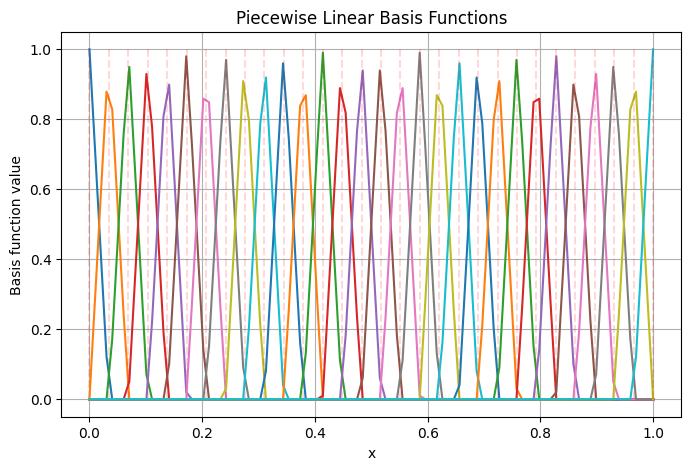

In [11]:
from basis_functions import BasisFunctions as bf

m = 30
delta_m = 1 / m


knots = np.linspace(0, 1, m)

basis = bf(m= m)
basis.plot_basis_functions(dim=0)


In [12]:
def get_linear_constraint_coefficients(self, knots):

	m_spread = self.m_scaler.inverse(1) - self.m_scaler.inverse(0)
	y_max, y_min = self.y_scaler.max_, self.y_scaler.min_
	y_spread = y_max - y_min

	mean = self.f_tilde['function_val']

	f = self.y_scaler.inverse(mean) # S_y^-1(f_tilde(m_tilde))
	f_tilde_prime = self.f_tilde['first_derivative'] 

	C_m = 1/m_spread
	C_y = y_spread / self.y_scaling_factor

	m = self.m_scaler.inverse(knots) # S_m^-1(m_tilde)

	component_1 = ((m * C_y * C_m) / (2 * f))**2 * f_tilde_prime
	component_2 = (C_y * C_m / 2)**2 * ( 1/f + 0.25) * f_tilde_prime
	component_3 = m * C_y * C_m / f

	gamma = (component_1 - component_2 - component_3)
	kappa = C_y * C_m**2 / 2

	return gamma, kappa

In [13]:
phi, kappa = get_linear_constraint_coefficients(Smile_TIV, knots)

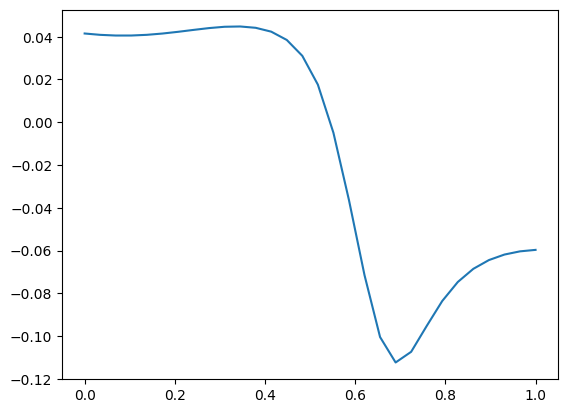

In [14]:
from matplotlib import pyplot as plt
plt.plot(knots, phi, label = 'gamma')

Once we have calculated our approximate linear constraint, next step is to implement it based on finite differences for our constrained GP. Note that, we have picked the knots

\begin{equation}\nonumber
\mathbb{M} = \{\tilde{m}_1, \tilde{m}_2, \ldots, \tilde{m}_N \}
\end{equation}

where we define the functions value there as

\begin{equation}\nonumber
\xi_i = \tilde{f}(\tilde{m}_i)
\end{equation}


Then, we approximate the first derivative as:
* Interior points

\begin{equation} \nonumber
\tilde{f}'(\tilde{m}_i) \approx \frac{\xi_{i+1} - \xi_{i-1}}{2h}, \quad \text{for } 2 \leq i \leq N-1
\end{equation}


* Left boundary -- forward difference
\begin{equation} \nonumber
\tilde{f}'(\tilde{m}_1) \approx \frac{\xi_2 - \xi_1}{h}
\end{equation}


* Right boundary -- backward difference
\begin{equation} \nonumber
\tilde{f}'(\tilde{m}_N) \approx \frac{\xi_N - \xi_{N-1}}{h}
\end{equation}


Similarly we approximate the second derivative as follows:

* Interior points

\begin{equation}\nonumber
\tilde{f}''(\tilde{m}_i) \approx \frac{\xi_{i+1} - 2\xi_i + \xi_{i-1}}{h^2}, \quad \text{for } 2 \leq i \leq N-1
\end{equation}

* Left boundary
\begin{equation}\nonumber
\tilde{f}''(\tilde{m}_1) \approx \frac{-\xi_3 + 4\xi_2 - 3\xi_1}{h^2}
\end{equation}

* Right boundary
\begin{equation}\nonumber
\tilde{f}''(\tilde{m}_N) \approx \frac{-\xi_{N-2} + 4\xi_{N-1} - 3\xi_N}{h^2}
\end{equation}




Thus we can rewrite our constraint after substituting for the finite difference approximations as:

* Interior points

\begin{equation} \nonumber
\small
\phi_i \cdot \frac{\xi_{i+1} - \xi_{i-1}}{2h}
+
\kappa \cdot \frac{\xi_{i+1} - 2\xi_i + \xi_{i-1}}{h^2}
\geq -1
\end{equation}

\begin{equation} \nonumber
\small
\left( -\frac{\phi_i}{2h} + \frac{\kappa}{h^2} \right) \xi_{i-1}
+
\left( -\frac{2\kappa}{h^2} \right) \xi_i
+
\left( \frac{\phi_i}{2h} + \frac{\kappa}{h^2} \right) \xi_{i+1}
\geq -1
\end{equation}

* Left boundary

\begin{equation} \nonumber
\small
\phi_1 \cdot \frac{\xi_2 - \xi_1}{h}
+
\kappa \cdot \frac{-\xi_3 + 4\xi_2 - 3\xi_1}{h^2}
\geq -1
\end{equation}

\begin{equation} \nonumber
\small
\left( -\frac{3\kappa}{h^2} - \frac{\phi_1}{h} \right) \xi_1
+
\left( \frac{4\kappa}{h^2} + \frac{\phi_1}{h} \right) \xi_2
+
\left( -\frac{\kappa}{h^2} \right) \xi_3
\geq -1
\end{equation}


* Right boundary

\begin{equation} \nonumber
\small
\phi_N \cdot \frac{\xi_N - \xi_{N-1}}{h}
+
\kappa \cdot \frac{-\xi_{N-2} + 4\xi_{N-1} - 3\xi_N}{h^2}
\geq -1
\end{equation}

\begin{equation} \nonumber
\small
\left( -\frac{\kappa}{h^2} \right) \xi_{N-2}
+
\left( \frac{4\kappa}{h^2} - \frac{\phi_N}{h} \right) \xi_{N-1}
+
\left( -\frac{3\kappa}{h^2} + \frac{\phi_N}{h} \right) \xi_N
\geq -1
\end{equation}






Finally, we express the discretized inequality constraint at each point $ \tilde{m}_i $ as a linear system:

$$
\Lambda \, \xi \geq -\mathbf{1}
$$

where:
- $ \xi = (\xi_1, \xi_2, \dots, \xi_N)^\top $ with $ \xi_i = \tilde{f}(\tilde{m}_i) $,
- $ \phi_i = \phi(\tilde{m}_i) $,
- $ \kappa $ is a constant,
- $ h $ is the uniform grid spacing.

The matrix $ \Lambda \in \mathbb{R}^{N \times N} $ is sparse. For interior rows $ i = 2, \dots, N-1 $, we use:

$$
\Lambda_{i, i-1} = -\frac{\phi_i}{2h} + \frac{\kappa}{h^2}, \quad
\Lambda_{i, i}   = -\frac{2\kappa}{h^2}, \quad
\Lambda_{i, i+1} = \frac{\phi_i}{2h} + \frac{\kappa}{h^2}
$$

At the boundaries, we apply one-sided finite differences:

- Left boundary ($ i = 1 $):

$$
\Lambda_{1,1} = -\frac{3\kappa}{h^2} - \frac{\phi_1}{h}, \quad
\Lambda_{1,2} = \frac{4\kappa}{h^2} + \frac{\phi_1}{h}, \quad
\Lambda_{1,3} = -\frac{\kappa}{h^2}
$$

- Right boundary ($ i = N $):

$$
\Lambda_{N,N-2} = -\frac{\kappa}{h^2}, \quad
\Lambda_{N,N-1} = \frac{4\kappa}{h^2} - \frac{\phi_N}{h}, \quad
\Lambda_{N,N}   = -\frac{3\kappa}{h^2} + \frac{\phi_N}{h}
$$

The first few rows of $ \Lambda $ follow this pattern:

$$
\Lambda =
\begin{bmatrix}
-\frac{3\kappa}{h^2} - \frac{\phi_1}{h} & \frac{4\kappa}{h^2} + \frac{\phi_1}{h} & -\frac{\kappa}{h^2} & 0 & \cdots \\
\ast & \ast & \ast & \cdots & 0 \\
\vdots & \ddots & \ddots & \ddots & \vdots \\
0 & \cdots & -\frac{\kappa}{h^2} & \frac{4\kappa}{h^2} - \frac{\phi_N}{h} & -\frac{3\kappa}{h^2} + \frac{\phi_N}{h}
\end{bmatrix}
$$


In [15]:
import numpy as np

def build_constraint_matrix(N, h, phi, kappa):
    """
    Construct the NxN matrix Lambda such that Lambda @ xi >= -1
    where xi = [f(m_1), ..., f(m_N)] and
    the inequality is: phi_i * f'(m_i) + kappa * f''(m_i) >= -1

    Parameters:
        N     : int        -- number of grid points
        h     : float      -- grid spacing (uniform)
        phi   : ndarray    -- shape (N,), values of phi_i at each point
        kappa : float      -- fixed scalar multiplier of second derivative

    Returns:
        Lambda : ndarray of shape (N, N)
        b      : ndarray of shape (N,), equal to -1
    """
    Lambda = np.zeros((N, N))
    b = -np.ones(N)

    for i in range(N):
        if i == 0:
            # Left boundary
            Lambda[i, 0] = -3 * kappa / h**2 - phi[i] / h
            Lambda[i, 1] =  4 * kappa / h**2 + phi[i] / h
            Lambda[i, 2] = -1 * kappa / h**2

        elif i == N - 1:
            # Right boundary
            Lambda[i, N-3] = -1 * kappa / h**2
            Lambda[i, N-2] =  4 * kappa / h**2 - phi[i] / h
            Lambda[i, N-1] = -3 * kappa / h**2 + phi[i] / h

        else:
            # Interior points
            Lambda[i, i-1] = -phi[i] / (2*h) + kappa / h**2
            Lambda[i, i]   = -2 * kappa / h**2
            Lambda[i, i+1] =  phi[i] / (2*h) + kappa / h**2

    return Lambda, b

In [16]:
Lambda, ll = build_constraint_matrix(
										N = m,
										h = 1/m,
										phi = phi,
										kappa = kappa
									)

### Motivation for Anchoring

We impose an additional constraint on one coefficient of $\xi$ to "anchor" the function. This procedure prevents vertical drift and stabilizes both the posterior mode and posterior sampling.

### Anchoring Strategy

The proposed anchoring strategy is based on identifying the minimum observed value:

1. Find the training point with the lowest observed target value:

\begin{equation} \nonumber
x_{\min} = \arg\min_{x_i} y_i.
\end{equation}

2. Identify the basis function index $j^\ast$ whose associated knot is closest to $x_{\min}$.

3. Impose a constraint on $\xi_{j^\ast}$ to lie within a narrow interval centered around $y_{\min}$:

\begin{equation} \nonumber
\xi_{j^\ast} \in [y_{\min} - \delta,\; y_{\min} + \delta],
\end{equation}

where $\delta = \max(5\sqrt{\sigma^2_{i^\ast}}, \varepsilon)$, and $\sigma^2_{i^\ast}$ is the observation noise at $x_{\min}$, with $\varepsilon$ acting as a numerical safeguard.

### Linear Constraint Form

This constraint is equivalent to adding a single row to the system of linear constraints:

\begin{equation} \nonumber
\Lambda_{\text{anchor}} \xi \leq u_{\text{anchor}}, \quad \Lambda_{\text{anchor}} \xi \geq \ell_{\text{anchor}},
\end{equation}

where

\begin{equation} \nonumber
\Lambda_{\text{anchor}} = e_{j^\ast}^\top, \quad
\ell_{\text{anchor}} = y_{\min} - \delta, \quad
u_{\text{anchor}} = y_{\min} + \delta.
\end{equation}

This ensures that the function is anchored at a meaningful point in the data, eliminating ambiguity in vertical alignment and improving the identifiability and numerical stability of the constrained GP model.


In [17]:
def make_anchor_constraint_from_min_obs(x_train, y_train, noise, knots, m, epsilon=1e-6):
    """
    Generate an anchoring constraint by identifying the training point with the minimum y-value
    and anchoring the closest knot in the basis function expansion.

    Parameters
    ----------
    x_train : array-like, shape (n,) or (n, 1)
        Training inputs (unnormalized, real domain).
    y_train : array-like, shape (n,)
        Training targets.
    noise : array-like, shape (n,) or scalar
        Observation noise values for each training point.
    knots : array-like, shape (m,)
        Locations of the knots used in the basis.
    m : int
        Number of basis functions (i.e., length of `knots`).
    epsilon : float
        Minimum spread allowed for anchoring (to avoid degeneracy).

    Returns
    -------
    Lambda_anchor : ndarray of shape (1, m)
        A row vector selecting one coefficient for anchoring.
    lower_anchor : float
        Lower bound on that coefficient.
    upper_anchor : float
        Upper bound on that coefficient.
    """
    x_train = np.asarray(x_train).squeeze()
    y_train = np.asarray(y_train).squeeze()
    noise = np.asarray(noise).squeeze()
    knots = np.asarray(knots).squeeze()

    if x_train.ndim != 1:
        raise ValueError("x_train must be 1-dimensional after squeezing.")
    if y_train.ndim != 1:
        raise ValueError("y_train must be 1-dimensional.")
    if noise.ndim == 0:
        noise = np.full_like(y_train, noise)  # broadcast scalar noise

    # Step 1: Find index of minimum y
    min_idx = np.argmin(y_train)
    x_min = x_train[min_idx]
    y_min = y_train[min_idx]

    # Step 2: Compute spread
    delta = max(5 * np.sqrt(noise[min_idx]), epsilon)

    # Step 3: Find closest knot
    closest_knot_idx = np.argmin(np.abs(knots - x_min))

    # Step 4: Build linear constraint row
    Lambda_anchor = np.zeros((1, m))
    Lambda_anchor[0, closest_knot_idx] = 1.0

    lower_anchor = y_min - delta
    upper_anchor = y_min + delta

    return Lambda_anchor, lower_anchor, upper_anchor


In [18]:
x_train = Smile_TIV.x_train.cpu().detach().numpy()
y_train = Smile_TIV.y_train.cpu().detach().numpy()
noise = Smile_TIV.noise.cpu().detach().numpy()
noise_matrix = np.diag(noise)
out_scale = Smile_TIV.kernel_params['outputscale']
len_scale = Smile_TIV.kernel_params['lengthscale']

Lambda_anchor, lower_anchor, upper_anchor = make_anchor_constraint_from_min_obs(
											x_train, 
											y_train, 
											noise, knots, 
											m, 
											epsilon=1e-6)

In [19]:
constr_matrix = np.vstack((Lambda, Lambda_anchor))
lower_limit = np.hstack((ll, lower_anchor)) #* Smile_TIV.y_scaling_factor / y_spread
upper_limit = np.hstack((np.ones_like(ll) * np.inf, upper_anchor)) #* Smile_TIV.y_scaling_factor / y_spread

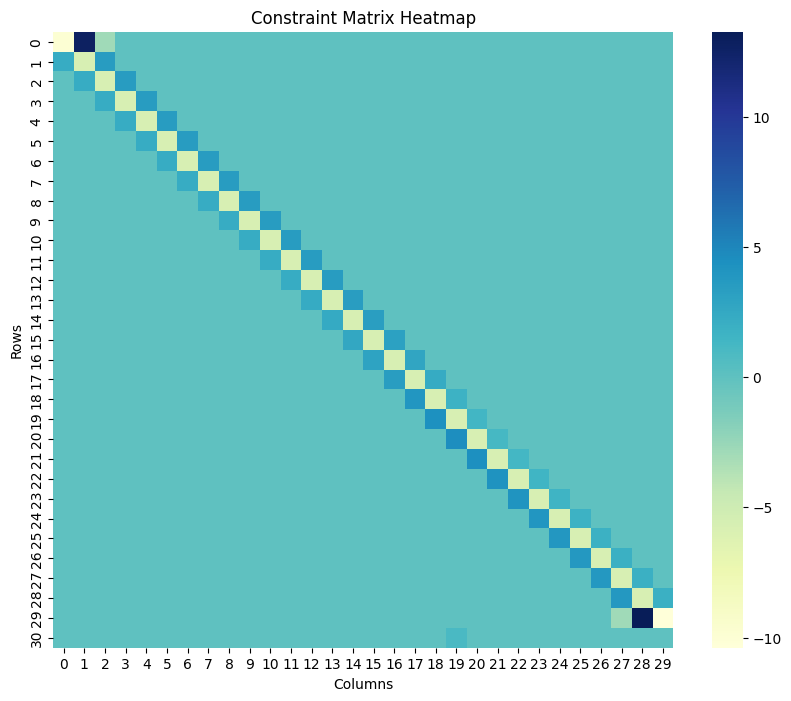

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the constraint matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(constr_matrix, cmap="YlGnBu", cbar=True, annot=False, fmt=".2f")
plt.title("Constraint Matrix Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

In [18]:
import numpy as np
import torch
import cvxpy as cp
from scipy.linalg import pinvh, pinv
import matplotlib.pyplot as plt
import warnings
import jax
import jax.numpy as jnp
from jax import random, lax
from basis_functions import BasisFunctions

class ConstrainedGPFromBase:
    def __init__(
        self,
        base_gp,
        constraint_matrix=None,
        lower_bound=None,
        upper_bound=None,
        basis_kwargs=None
    ):
        """
        Constrained GP model using projection onto basis functions, initialized from a trained base GP.

        Parameters:
        - base_gp: Trained Base_GP_Model object (unconstrained GP).
        - constraint_matrix: np.ndarray or None, linear inequality constraint matrix (Λ).
        - lower_bound: np.ndarray or None, lower bounds for Λξ.
        - upper_bound: np.ndarray or None, upper bounds for Λξ.
        - basis_kwargs: dict or None, passed to BasisFunctions (e.g. {'m': 30}, {'delta_m': 0.05}, {'knots': [...]})
        
        Example usage of ConstrainedGPFromBase:

        1. Basic usage with default basis configuration (auto m and d):
            >>> constrained_gp = ConstrainedGPFromBase(base_gp)

        2. Specify number of knots (m):
            - For 1D:
            >>> constrained_gp = ConstrainedGPFromBase(base_gp, basis_kwargs={'m': 25})

            - For 2D:
            >>> constrained_gp = ConstrainedGPFromBase(base_gp, basis_kwargs={'m': [20, 15]})

        3. Specify knot spacing instead of number:
            >>> constrained_gp = ConstrainedGPFromBase(base_gp, basis_kwargs={'delta_m': [0.05, 0.1]})

        4. Provide explicit knot locations (must match input dimension):
            >>> knots_1d = [np.linspace(0, 1, 30)]
            >>> constrained_gp = ConstrainedGPFromBase(base_gp, basis_kwargs={'knots': knots_1d})

            >>> knots_2d = [np.linspace(0, 1, 25), np.linspace(0, 1, 30)]
            >>> constrained_gp = ConstrainedGPFromBase(base_gp, basis_kwargs={'knots': knots_2d})

        Note:
        - `d` (dimension) is automatically inferred from the base GP.
        - Constraints (`constraint_matrix`, `lower_bound`, `upper_bound`) can also be passed at initialization.
        - If no `basis_kwargs` is provided, the default is m=20 for 1D, m=[15,15,...] for d>1.
                
        """
        self.base_gp = base_gp
        self.data = base_gp.data
        self.constraint_matrix = constraint_matrix
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

        # Scaling functions for m, T and y.
        self.m_scaler = base_gp.m_scaler
        self.T_scaler = base_gp.T_scaler
        self.y_scaler = base_gp.y_scaler

        # Determine input dimension from base GP
        self.input_dim = base_gp.input_dim
        self.y_label = base_gp.y_label
        self.sep_obs = base_gp.sep_obs

        # Create basis functions (user can pass m, delta_m, or knots)
        if basis_kwargs is None:
            # default: 1D → m=20, 2D → m=[15,15]
            default_m = 20 if self.input_dim == 1 else [15] * self.input_dim
            basis_kwargs = {'m': default_m, 'd': self.input_dim}
        else:
            if 'd' not in basis_kwargs:
                basis_kwargs['d'] = self.input_dim

        self.basis = BasisFunctions(**basis_kwargs)
        self.m = self.basis.m  # save for convenience

        # Extract training data from base GP
        self.x_train = base_gp.x_train.detach().cpu().numpy()
        self.y_train = base_gp.y_train.detach().cpu().numpy()

        # Extract learned kernel and wrap it to a NumPy-compatible callable
        full_kernel = base_gp.model.covar_module
        self.kernel = self._wrap_gpytorch_kernel(full_kernel)

        # Noise: Use base GP’s estimated observation noise if available
        self.noise = np.diag(base_gp.noise.detach().cpu().numpy()) if base_gp.noise is not None else np.eye(self.y_train.shape[1])* 1e-6

        # Posterior placeholders
        self.mu = None
        self.Sigma = None
        self.mu_star = None
        self.posterior_samples = None

    def fit(self, solver = 'SCS'):
        """
        Compute the unconstrained (and optionally constrained) posterior
        for the finite-dimensional GP using the given base GP.

        Parameters:
            solver (str): Solver for the optimization problem. Default is 'SCS'.
                        Avaliable solvers: ['CLARABEL', 'OSQP', 'SCIPY', 'SCS']   

        Returns:
            mu (np.ndarray): Unconstrained posterior mean
            Sigma (np.ndarray): Unconstrained posterior covariance
            mu_star (np.ndarray or None): Constrained posterior mode, if constraints are provided
        """

        # Step 1: Basis matrix Φ (n_samples x m_total)
        Phi = self.basis.basis_matrix(self.x_train)  # stays in NumPy for now

        # Step 2: Kernel matrix Γ over knots (m_total x m_total)
        Gamma = self._compute_gamma()  # shape (m_total, m_total)
        y = self.y_train

        # Step 3: Σ_y = ΦΓΦᵀ + Σ_noise
        Sigma_y = Phi @ Gamma @ Phi.T + self.noise
        common_term = Gamma @ Phi.T @ np.linalg.inv(Sigma_y)
        self.Sigma_y = Sigma_y

        # Try to add later on.!!!!
        # Step 4: Inverse Σ_y
        #try:
        #    L = torch.linalg.cholesky(Sigma_y)
        #    inv_Sigma_y = torch.cholesky_inverse(L)
        #except RuntimeError:
        #    inv_Sigma_y = torch.linalg.pinv(Sigma_y)
        #    # Warning:
        #    print("Cholesky decomposition failed, using pseudo-inverse instead.")

        # Step 5: Posterior mean and covariance

        μ = common_term @ y
        Σ = Gamma - common_term @ Phi @ Gamma

        self.mu = μ
        self.Phi = Phi
        self.Sigma = Σ
        Λ = self.constraint_matrix

        mean_eta = Λ @ μ
        #if self.mu_star is not None:
            #mean_star_eta =  (Λ @ self.mu_star)
        cov_eta =   (Λ @ Σ @ Λ.T) + 1e-6 * np.eye(Λ.shape[0])
        lower_eta =  (self.lower_bound if self.lower_bound is not None else -np.inf * np.ones_like(mean_eta))
        upper_eta =  (self.upper_bound if self.upper_bound is not None else np.inf * np.ones_like(mean_eta))

        results_eta = {
            'mean_eta': mean_eta,
            'cov_eta': cov_eta,
            'lower_eta': lower_eta,
            'upper_eta': upper_eta
        }
        self.eta_parameters = results_eta

        # Step 6: Optionally apply linear constraints
        if self.constraint_matrix is not None and (
            self.lower_bound is not None or self.upper_bound is not None
        ):
            self.mu_star = self.compute_constrained_mode(self.mu, self.Sigma, solver=solver)
        else:
            self.mu_star = None

        return self

    def compute_constrained_mode(self, mu, Sigma, solver='SCS'):

        m = mu.shape[0]
        Lambda = self.constraint_matrix
        lb = self.lower_bound
        ub = self.upper_bound

        # Scale things to avoid extreme values
        #mu_scale = np.max(np.abs(mu))
        #mu = mu / mu_scale
        #lb = lb / mu_scale if lb is not None else None
        #ub = ub / mu_scale if ub is not None else None

        # Strong regularization to avoid ill-conditioning
        jitter = 1e-4
        Sigma_reg = Sigma + jitter * np.eye(m)
        Q_np = pinv(Sigma_reg) # / (mu_scale**2)

        Q = cp.psd_wrap(Q_np)
        p = -Q @ mu
        xi = cp.Variable(np.prod(self.basis.m))

        constraints = []
        if lb is not None:
            constraints.append(Lambda @ xi >= lb)
        if ub is not None:
            constraints.append(Lambda @ xi <= ub)

        problem = cp.Problem(cp.Minimize(0.5 * cp.quad_form(xi, Q) + p.T @ xi), constraints)
        problem.solve(solver=solver, verbose=False)

        if problem.status not in [cp.OPTIMAL, cp.OPTIMAL_INACCURATE]:
            raise RuntimeError(f"QP failed: {problem.status}")
        
        return xi.value  # * mu_scale  # scale back to original units

    def sample_posterior(self, sampler=None, num_samples=500, numerical_stability=1, seed=0, **kwargs):
        """
        Sample from the constrained posterior using a custom or default truncated Gaussian sampler.

        Parameters:
        - sampler: an instance of a sampler from TMN_sampler.py (e.g. TruncatedGaussianGHKSampler)
        - num_samples: number of samples to draw
        - numerical_stability: scaling factor for better conditioning
        - seed: random seed for reproducibility
        - kwargs: passed to sampler.sample()

        Returns:
        - posterior_samples: (num_samples, m) samples of ξ
        """
        if self.constraint_matrix is None:
            return np.random.multivariate_normal(self.mu, self.Sigma, num_samples)

        # TO BE FIXED#
        #mean_eta[0] = self.lower_bound[0]
        #mean_eta[-1] = self.lower_bound[-1]
        # TO BE FIXED

        # JAX input conversion
        #mean_eta_jax = jnp.array(mean_eta)
        #if self.mu_star is not None:
        #    #mean_star_eta_jax = jnp.array(mean_star_eta)
        #cov_eta_jax = jnp.array(cov_eta)
        #lower_eta_jax = jnp.array(lower_eta)
        #upper_eta_jax = jnp.array(upper_eta)

        def trunc_normal(mean, cov, lower, upper, num_samples, max_iter=10e5):
            final_samples = []
            iter = 0
            while len(final_samples) < num_samples and (iter < max_iter):
                samples = np.random.multivariate_normal(mean, cov, num_samples)
                samples = samples[((samples > lower) & (samples < upper)).all(axis=1)]
                reflected_samples = 2*mean - samples
                reflected_samples = reflected_samples[((reflected_samples > lower) & (reflected_samples < upper)).all(axis=1)]
                samples = np.vstack((samples, reflected_samples))
                for sample in samples:
                    if len(final_samples) < num_samples:
                        final_samples.append(sample)
                    else:
                        break
                iter += 1
            return np.array(final_samples)

        filtered_samples = trunc_normal(self.eta_parameters['mean_eta'], 
										self.eta_parameters['cov_eta'],
										self.eta_parameters['lower_eta'],
										self.eta_parameters['upper_eta'],
										num_samples=num_samples)
        #filtered_samples = samples[np.all(samples >= lower_eta, axis=1)]
        filtered_samples = filtered_samples / numerical_stability

        Λ = self.constraint_matrix
        Λ_pinv = np.linalg.pinv(Λ)
        xi_samples = Λ_pinv @ filtered_samples.T

        self.posterior_samples = xi_samples.T
        self.eta_samples = filtered_samples

        return self

    def predict(self, add_x_test=None, add_label=None):
        """
        Predict the posterior mean and 95% confidence intervals at test inputs.

        Parameters:
        - x_test: normalized test inputs, shape (n, d)
        - label: optional string to tag predictions (for multiple test sets)

        Returns:
        - Dictionary with keys: 'mean', 'lower', 'upper', 'variance'
        """
        if self.posterior_samples is None or self.eta_samples.shape[0] == 0:
            raise RuntimeError("You must sample from the posterior before predict().")

        dim = self.input_dim

        if dim == 1:
            x_test = self.m_scaler.normalize(self.data['m'].values)
        elif dim == 2:
            x_test = self.m_scaler.normalize(self.data['m'].values)
            x_test = np.column_stack((x_test, self.T_scaler.normalize(self.data['T'].values)))
        else:
            raise ValueError("Prediction only supported for 1D or 2D.")

        self.pred = self._get_pred(x_test)        
        if add_x_test is not None:
            if add_label is None:
                warnings.warn("add_label is None. Setting it to 'extra'")
                add_label = 'extra'
            predictions = self._get_pred(add_x_test, label=add_label)
            setattr(self, f"pred_{add_label}", predictions)
        
        return self

    def _get_pred(self, x_test, label = None):
        """
        Compute the posterior mean and covariance at test inputs.

        Parameters:
        - x_test: normalized test inputs, shape (n, d)

        Returns:
        - mu_star: posterior mean
        - Sigma_star: posterior covariance
        """
        Phi_test = self.basis.basis_matrix(x_test)  # shape (n_test, m_total)
        test_samples = Phi_test @ self.posterior_samples.T  # shape (n_test, n_samples)
        test_samples = self.y_scaler.inverse(test_samples)

        pred_mean = test_samples.mean(axis=1)
        pred_lower = np.quantile(test_samples, 0.025, axis=1)
        pred_upper = np.quantile(test_samples, 0.975, axis=1)
        pred_var = test_samples.var(axis=1)

        if self.basis.d == 1:
            setattr(self, f"x_test_{label}", self.m_scaler.inverse(x_test))
            if label is None:
                self.x_test = self.m_scaler.inverse(x_test)
            else:
                setattr(self, f"x_test_{label}", self.m_scaler.inverse(x_test))

        elif self.basis.d == 2:
            m = self.m_scaler.inverse(x_test[:, 0])
            T = self.T_scaler.inverse(x_test[:, 1])
            if label is None:
                self.m_test = m
                self.T_test = T
                self.x_test = np.column_stack([m, T])
            else:
                setattr(self, f"m_test_{label}", m)
                setattr(self, f"T_test_{label}", T)
        else:
            raise ValueError("Prediction only supported for 1D or 2D.")

        results = {
            'mean': pred_mean,
            'lower': pred_lower,
            'upper': pred_upper,
            'variance': pred_var
        }

        return results

    def _compute_gamma(self):
        m_total = np.prod(self.basis.m)
        d = self.basis.d

        if d == 1:
            knots = self.basis.knots[0]  # shape (m,)
            knots = knots[:, None]  # shape (m, 1)
            Gamma_np = self.kernel(knots, knots)  # shape (m, m)
        else:
            # Build full tensor product of knots (m_total, d)
            mesh = np.meshgrid(*self.basis.knots, indexing="ij")
            grid = np.stack(mesh, axis=-1).reshape(-1, d)  # shape (m_total, d)

            # Now compute kernel for each dimension separately
            Gamma_np = np.ones((m_total, m_total))
            for dim in range(d):
                k = self.kernel  # still assumes isotropic kernel, modify if ARD
                xi = grid[:, dim:dim+1]  # shape (m_total, 1)
                Gamma_np *= k(xi, xi.T)
		
        self.Gamma = Gamma_np
        return Gamma_np

    def _wrap_gpytorch_kernel(self, gp_kernel):
        device = next(gp_kernel.parameters()).device

        def kernel(x1, x2):
            x1_tensor = torch.tensor(x1, dtype=torch.float32, device=device)
            x2_tensor = torch.tensor(x2, dtype=torch.float32, device=device)
            with torch.no_grad():
                k_val = gp_kernel(x1_tensor, x2_tensor).evaluate()
            return k_val.cpu().numpy()

        return kernel

    def __plot_smile(self, figsize=(20, 10), ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)

        ax.fill_between(self.data['m'], self.data['adj_ask_' + self.y_label],
                        self.data['adj_bid_' + self.y_label], alpha=0.5,
                        label='Bid-Ask ' + self.y_label + ' Spread')
        ax.plot(self.data['m'], self.data['adj_mid_' + self.y_label],
                label='Mid-Price ' + self.y_label, color='b')
        ax.fill_between(self.x_test_extra, self.pred_extra['lower'],
                        self.pred_extra['upper'], alpha=0.5,
                        label='95% Confidence Interval for ' + self.y_label)
        ax.plot(self.x_test_extra, self.pred_extra['mean'],
                'r', label='Constrained GP Mean')
        ax.plot(self.m_scaler.inverse(self.x_train), self.y_train,
                'k*', label='Training Data', markersize=4)
        ax.set_xlabel('Moneyness')
        y_lab = 'Implied Volatility' if self.y_label == 'IV' else 'Total Implied Variance'
        ax.set_ylabel(y_lab)
        ax.set_title(f"{y_lab} vs Moneyness\n Expiry Date: {self.data['expiration'].iloc[0]} -- Quote Date: {self.data['quote_date'].iloc[0]}")
        ax.legend()
        return ax

    def __plot_smile_centered(self, figsize=(20, 10), zoom=0, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)

        center_around = self.pred_extra['mean']
        ax.fill_between(self.data['m'],
                        self.data['adj_ask_' + self.y_label] - center_around,
                        self.data['adj_bid_' + self.y_label] - center_around,
                        alpha=0.5, label='Bid-Ask Spread')
        ax.plot(self.data['m'],
                self.data['adj_mid_' + self.y_label] - center_around,
                label='Mid-Price', color='b')
        ax.fill_between(self.x_test_extra,
                        self.pred_extra['lower'] - center_around,
                        self.pred_extra['upper'] - center_around,
                        alpha=0.5, label='95% CI')
        ax.plot(self.x_test_extra,
                self.pred_extra['mean'] - center_around,
                'r', label='GP Mean Prediction')
        ax.plot(self.m_scaler.inverse(self.x_train),
                np.zeros_like(self.x_train),
                'k*', label='Training Locations', markersize=3)
        ax.set_xlabel('Moneyness')
        y_lab = 'Implied Volatility' if self.y_label == 'IV' else 'Total Implied Variance'
        ax.set_ylabel(y_lab)
        ax.set_title(f"{y_lab} - Centered around Mean Prediction\n Expiry: {self.data['expiration'].iloc[0]} -- Quote: {self.data['quote_date'].iloc[0]}")
        ax.legend(loc='lower center')
        if zoom > 0:
            y_min, y_max = ax.get_ylim()
            ax.set_ylim(y_min * zoom / 100, y_max * zoom / 100)
        return ax

    def plot_smile_comparison(self, figsize=(24, 10), zoom=0):
        with torch.no_grad():
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
            self._plot_smile(ax=ax2)
            self._plot_smile_centered(ax=ax1, zoom=zoom)
            plt.tight_layout()
            plt.show()
            return self

    def _plot_smile(self, figsize=(20, 10), ax=None):

        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
            
        for knot in self.basis.knots[0]:
            ax.axvline(x=self.m_scaler.inverse(knot), color='gray', linestyle='--', alpha=0.2)

        ax.fill_between(self.data['m'], self.data['adj_ask_' + self.y_label],
                        self.data['adj_bid_' + self.y_label], alpha=0.5,
                        label='Bid-Ask ' + self.y_label + ' Spread')
        ax.plot(self.data['m'], self.data['adj_mid_' + self.y_label],
                label='Mid-Price ' + self.y_label, color='b')
        
        ax.fill_between(self.x_test_extra,
                        self.base_gp.pred_extra['lower'],
                        self.base_gp.pred_extra['upper'], alpha=0.5,
                        label='Unconstrained 95% Confidence Interval for ' + self.y_label)       
        ax.plot(self.x_test_extra,
                self.base_gp.pred_extra['mean'],
                'r', label='Unconstrained GP Mean Prediction for ' + self.y_label)
        ax.fill_between(self.x_test_extra, self.pred_extra['lower'],
                        self.pred_extra['upper'], alpha=0.5,
                        label='Constrained 95% Confidence Interval for ' + self.y_label)
        ax.plot(self.x_test_extra, self.pred_extra['mean'],
                'purple', label='Constrained GP Mean Prediction for ' + self.y_label)
        ax.plot(self.m_scaler.inverse(self.x_train), self.y_scaler.inverse(self.y_train),
                'k*', label='Training Data', markersize=3)
        ax.set_xlabel('Moneyness')
        y_lab = 'Implied Volatility' if self.y_label == 'IV' else 'Total Implied Variance'
        obs_type = 'Two Separate Observations' if self.sep_obs else 'Single Observation'
        ax.set_ylabel(y_lab)
        ax.set_title(f"{y_lab} vs Moneyness\n Expiry Date: {self.data['expiration'].iloc[0]} -- Quote Date: {self.data['quote_date'].iloc[0]}\n Each Option: {obs_type}")
        ax.legend()
        return ax

    def _plot_smile_centered(self, figsize=(20, 10), zoom=0, ax=None):

        with torch.no_grad():
            
            center_around = self.pred['mean']
            center_around_extra = self.pred_extra['mean']
            if ax is None:
                fig, ax = plt.subplots(figsize=figsize)
            
            for knot in self.basis.knots[0]:
                ax.axvline(x=self.m_scaler.inverse(knot), color='gray', linestyle='--', alpha=0.2)
            
            ax.fill_between(self.data['m'], 
                            self.data['adj_ask_' + self.y_label].values - center_around, 
                            self.data['adj_bid_' + self.y_label].values - center_around,
                            alpha=0.5, label='Bid-Ask ' + self.y_label + ' Spread')
            ax.plot(self.data['m'], 
                    self.data['adj_mid_' + self.y_label] - center_around, 
                    label='Mid-Price ' + self.y_label, color='b')
            
            ax.fill_between(self.x_test_extra,
                            self.base_gp.pred_extra['lower'] - center_around_extra,
                            self.base_gp.pred_extra['upper'] - center_around_extra,
                            alpha=0.5, label='Unconstrained 95% Confidence Interval for ' + self.y_label)
            
            ax.plot(self.x_test_extra,
                    self.base_gp.pred_extra['mean'] - center_around_extra,
                    'r', label='Unconstrained GP Mean Prediction for ' + self.y_label)

            ax.fill_between(self.x_test_extra, 
                            self.pred_extra['lower'] - center_around_extra,  
                            self.pred_extra['upper'] - center_around_extra, 
                            alpha=0.5, label='Constrained 95% Confidence Interval for ' + self.y_label)
            ax.plot(self.x_test_extra, 
                    self.pred_extra['mean'] - center_around_extra, 
                    'purple', label='Constrained GP Mean Prediction for ' + self.y_label)
            ax.plot(self.m_scaler.inverse(self.x_train), 
                    np.zeros_like(self.x_train), 
                    'k*', label='Training Locations', markersize=3)
            ax.set_xlabel('Moneyness')
            y_lab = 'Implied Volatility' if self.y_label == 'IV' else 'Total Implied Variance'
            obs_type = 'Two Separate Observations' if self.sep_obs else 'Single Observation'
            ax.set_ylabel(y_lab)
            ax.set_title(f"{y_lab} - Centered around Mean Prediction\n Expiry Date: {self.data['expiration'].iloc[0]} -- Quote Date: {self.data['quote_date'].iloc[0]}\n Each Option: {obs_type}")
            ax.legend(loc='lower center')
            y_min, y_max = ax.get_ylim()
            y_range = y_max - y_min
            perc = zoom / 100 
            ax.set_ylim(y_min * perc, y_max * perc)
            return ax


In [19]:
from basis_functions import BasisFunctions

constrained_gp = ConstrainedGPFromBase(
    Smile_TIV,
	constraint_matrix=constr_matrix,
	lower_bound= lower_limit,
    upper_bound= upper_limit, 
	basis_kwargs={'m': m}
    )

constrained_gp.fit(
        solver='OSQP'
        )



In [20]:
constrained_gp.sample_posterior(
            num_samples=10,
            numerical_stability=1
            ).predict(
                knots,
                add_label = 'extra')

/tmp/ipykernel_254258/1151845460.py:246: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(mean, cov, num_samples)


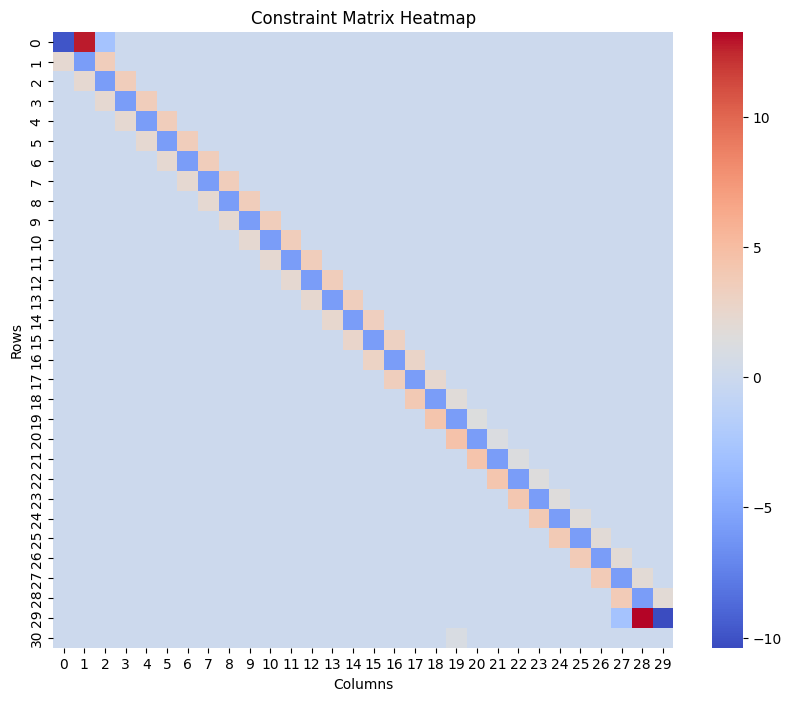

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the constraint matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(constrained_gp.constraint_matrix, cmap="coolwarm", cbar=True)
plt.title("Constraint Matrix Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

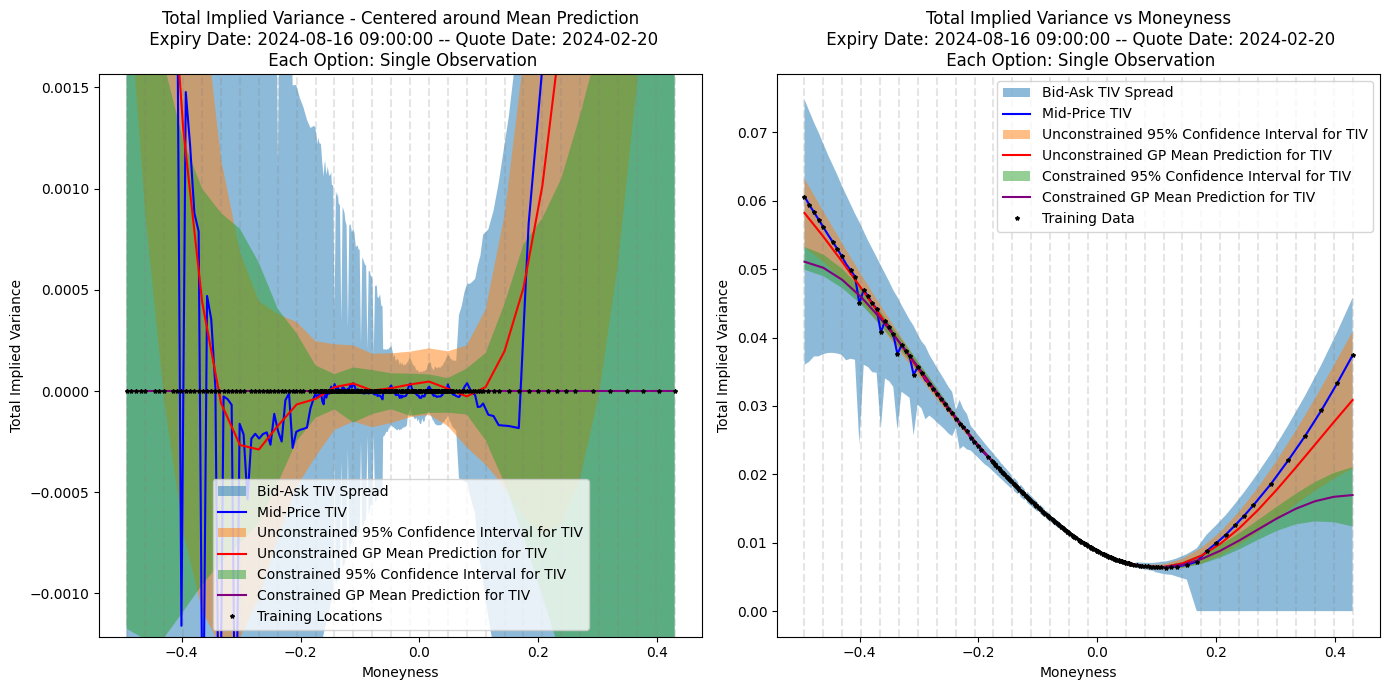

In [21]:
constrained_gp.plot_smile_comparison(figsize=(14, 7), zoom=5)

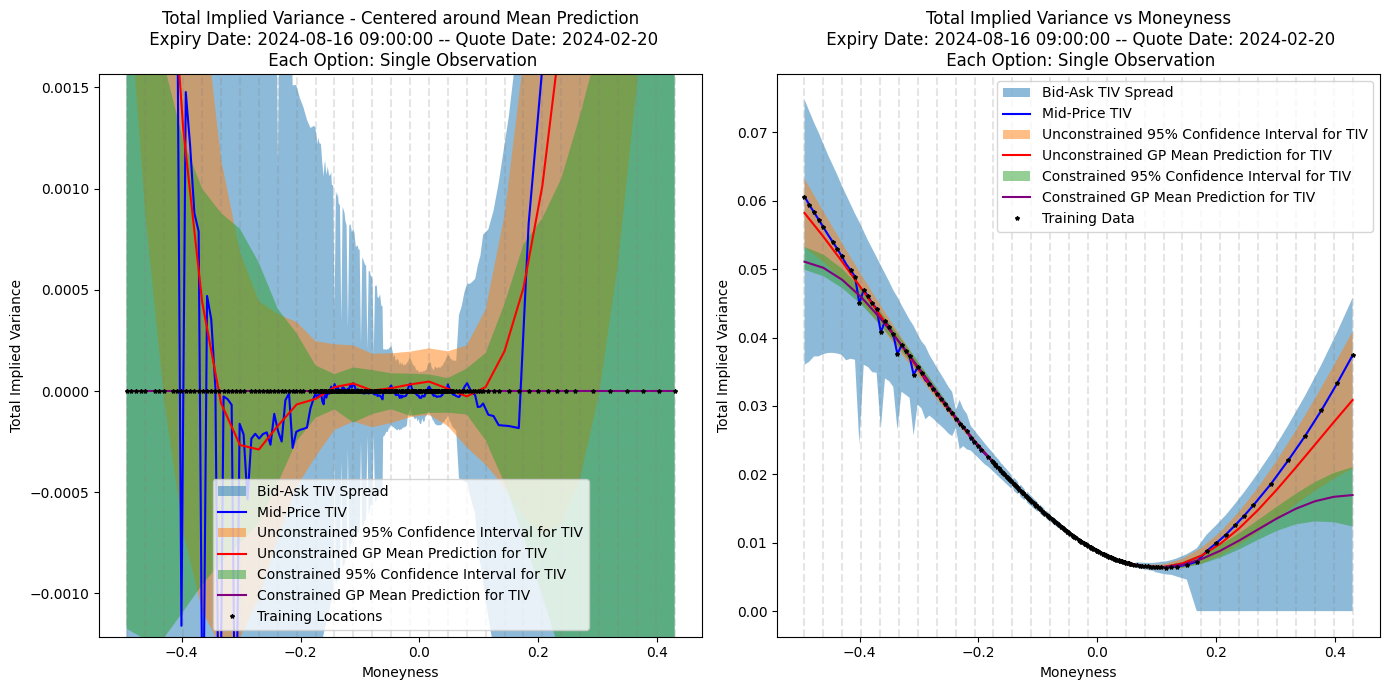

In [24]:
constrained_gp.plot_smile_comparison(figsize=(14, 7), zoom=5)

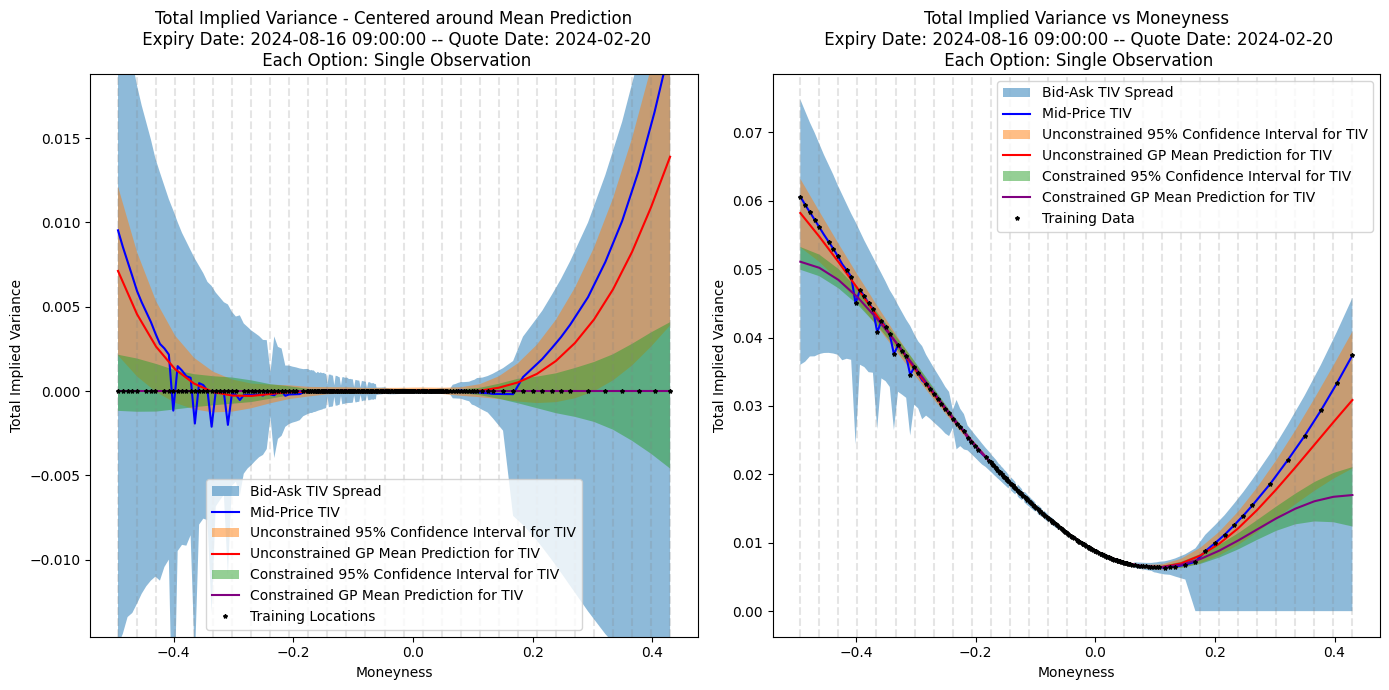

In [23]:
constrained_gp.plot_smile_comparison(figsize=(14, 7), zoom=60)

In [ ]:
class TruncatedGaussianHMCSampler(TruncatedGaussianSamplerBase):
    def __init__(self, mean, cov, lower, upper, step_size=0.01, n_steps=10, key=None):
        super().__init__(mean, cov, lower, upper, key)
        self.step_size = step_size
        self.n_steps = n_steps

    def sample(self, n_samples, burn_in=100, x0=None):
        if x0 is None:
            x0 = self._initial_point()

        def reflect(x, p):
            for i in range(self.d):
                out_lo = x[i] < self.lower[i]
                out_hi = x[i] > self.upper[i]

                x = x.at[i].set(jnp.where(out_lo, 2*self.lower[i] - x[i], x[i]))
                x = x.at[i].set(jnp.where(out_hi, 2*self.upper[i] - x[i], x[i]))

                p = p.at[i].set(jnp.where(out_lo | out_hi, -p[i], p[i]))

            return x, p

        def leapfrog(x, p):
            p = p - 0.5 * self.step_size * (self.P @ (x - self.mean))
            for _ in range(self.n_steps):
                x = x + self.step_size * p
                x, p = reflect(x, p)
                p = p - self.step_size * (self.P @ (x - self.mean))
            p = p + 0.5 * self.step_size * (self.P @ (x - self.mean))
            return x

        def hmc_step(x, key):
            p = random.normal(key, (self.d,))
            return leapfrog(x, p)

        @partial(jit, static_argnums=(2,))
        def _sample_impl(x0, key, n_samples):
            def body(carry, _):
                x, key = carry
                key, subkey = random.split(key)
                x = hmc_step(x, subkey)
                return (x, key), x

            (x0, key), _ = lax.scan(body, (x0, key), None, length=burn_in)
            (_, _), xs = lax.scan(body, (x0, key), None, length=n_samples)
            return xs

        return _sample_impl(x0, self.key, n_samples)


In [ ]:
import jax
import jax.numpy as jnp
from jax import random, jit, vmap, lax
from jax.scipy.linalg import cho_factor, cho_solve
from functools import partial

# Utility

def norm_ppf(u):
    return jnp.sqrt(2.0) * jax.scipy.special.erfinv(2.0 * u - 1.0)

@jit
def truncnorm_sample(key, a, b, shape=()):
    Phi = 0.5 * (1 + jax.scipy.special.erf(a / jnp.sqrt(2)))
    Phi_b = 0.5 * (1 + jax.scipy.special.erf(b / jnp.sqrt(2)))
    u = random.uniform(key, shape=shape, minval=Phi, maxval=Phi_b)
    return norm_ppf(u)

class TruncatedGaussianSamplerBase:
    def __init__(self, mean, cov, lower, upper, key=None):
        self.mean = jnp.array(mean)
        self.cov = jnp.array(cov)
        self.lower = jnp.array(lower)
        self.upper = jnp.array(upper)
        self.d = self.mean.shape[0]
        self.key = random.PRNGKey(0) if key is None else key
        self.L = jnp.linalg.cholesky(self.cov)
        cf = cho_factor(self.cov)
        self.P = cho_solve(cf, jnp.eye(self.d))

    def _initial_point(self):
        return jnp.clip(self.mean, self.lower + 1e-6, self.upper - 1e-6)

class TruncatedGaussianGibbsSampler(TruncatedGaussianSamplerBase):
    def sample(self, n_samples, burn_in=100, thinning=1, x0=None):
        if x0 is None:
            x0 = self._initial_point()

        @partial(jit, static_argnums=(2, 3, 4))
        def _sample_impl(x0, key, n_samples, burn_in, thinning):
            def step(carry, _):
                x, key = carry
                keys = random.split(key, self.d + 1)
                for i in range(self.d):
                    pii = self.P[i, i]
                    mu_i = self.mean[i] - (1.0 / pii) * (self.P[i] @ (x - self.mean))
                    std_i = jnp.sqrt(1.0 / pii)
                    a = (self.lower[i] - mu_i) / std_i
                    b = (self.upper[i] - mu_i) / std_i
                    z = truncnorm_sample(keys[i], a, b)
                    x = x.at[i].set(mu_i + std_i * z)
                return (x, keys[-1]), x

            (x0, key), _ = lax.scan(step, (x0, key), None, length=burn_in)
            (_, _), xs = lax.scan(step, (x0, key), None, length=n_samples * thinning)
            return xs[thinning - 1::thinning]

        return _sample_impl(x0, self.key, n_samples, burn_in, thinning)

class TruncatedGaussianGHKSampler(TruncatedGaussianSamplerBase):
    def sample(self, n_samples, x0=None):
        def _one_sample(key):
            zs = jnp.zeros(self.d)
            x = jnp.zeros(self.d)
            for i in range(self.d):
                key, sub = random.split(key)
                mu_partial = self.mean[i] + (self.L[i, :i] @ zs[:i])
                Li = self.L[i, i]
                a = (self.lower[i] - mu_partial) / Li
                b = (self.upper[i] - mu_partial) / Li
                z = truncnorm_sample(sub, a, b)
                zs = zs.at[i].set(z)
                x = x.at[i].set(mu_partial + Li * z)
            return x
        return vmap(_one_sample)(random.split(self.key, n_samples))

class TruncatedGaussianMinimaxTiltingSampler(TruncatedGaussianSamplerBase):
    def sample(self, n_samples, x0=None):
        @partial(jit, static_argnums=(0,))
        def _sample_impl(n_samples):
            def body(carry, _):
                samples, key = carry
                key, sub = random.split(key)
                z = random.normal(sub, (self.d,))
                x = self.mean + self.L @ z
                inside = jnp.all((x >= self.lower) & (x <= self.upper))
                return (samples, key), jnp.where(inside, x, jnp.zeros_like(x))
            (samples, _), out = lax.scan(body, (jnp.zeros((n_samples, self.d)), self.key), None, length=n_samples)
            return out
        return _sample_impl(n_samples)

class TruncatedGaussianSliceSampler(TruncatedGaussianSamplerBase):
    def sample(self, n_samples, burn_in=100, thinning=1, x0=None):
        if x0 is None:
            x0 = self._initial_point()

        @partial(jit, static_argnums=(2, 3, 4))
        def _sample_impl(x0, key, n_samples, burn_in, thinning):
            def update(carry, _):
                x, key = carry
                key, sub = random.split(key)
                logp = -0.5 * (x - self.mean) @ self.P @ (x - self.mean)
                key, u_key = random.split(key)
                logy = logp + jnp.log(random.uniform(u_key))
                for i in range(self.d):
                    var = 1.0 / self.P[i, i]
                    w = jnp.sqrt(var)
                    L = jnp.maximum(self.lower[i], x[i] - w * random.uniform(key))
                    R = jnp.minimum(self.upper[i], L + w)
                    key, sub2 = random.split(key)
                    x = x.at[i].set(random.uniform(sub2, minval=L, maxval=R))
                return (x, key), x
            (x0, key), _ = lax.scan(update, (x0, key), None, length=burn_in)
            (_, _), xs = lax.scan(update, (x0, key), None, length=n_samples * thinning)
            return xs[thinning - 1::thinning]

        return _sample_impl(x0, self.key, n_samples, burn_in, thinning)

class TruncatedGaussianHMCSampler(TruncatedGaussianSamplerBase):
    def __init__(self, mean, cov, lower, upper, step_size=0.1, n_steps=10, key=None):
        super().__init__(mean, cov, lower, upper, key)
        self.step_size = step_size
        self.n_steps = n_steps

    def sample(self, n_samples, burn_in=100, x0=None):
        if x0 is None:
            x0 = self._initial_point()

        def _hmc_step(x, key):
            key, p_key = random.split(key)
            p = random.normal(p_key, (self.d,))
            def leapfrog(carry, _):
                x, p = carry
                p = p - 0.5 * self.step_size * (self.P @ (x - self.mean))
                x = x + self.step_size * p
                x = jnp.where(x < self.lower, 2 * self.lower - x, x)
                x = jnp.where(x > self.upper, 2 * self.upper - x, x)
                p = jnp.where((x < self.lower) | (x > self.upper), -p, p)
                p = p - 0.5 * self.step_size * (self.P @ (x - self.mean))
                return (x, p), None
            (x_new, _), _ = lax.scan(leapfrog, (x, p), None, length=self.n_steps)
            return x_new, key

        @partial(jit, static_argnums=(2,))
        def _sample_impl(x0, key, n_samples):
            def body(carry, _):
                x, key = carry
                x, key = _hmc_step(x, key)
                return (x, key), x
            (x0, key), _ = lax.scan(body, (x0, key), None, length=burn_in)
            (_, _), xs = lax.scan(body, (x0, key), None, length=n_samples)
            return xs

        return _sample_impl(x0, self.key, n_samples)

class TruncatedGaussianRejectionSampler(TruncatedGaussianSamplerBase):
    def sample(self, n_samples, x0=None):
        def one_sample(key):
            z = random.normal(key, (self.d,))
            return self.mean + self.L @ z
        return vmap(one_sample)(random.split(self.key, n_samples))

class TruncatedGaussianImportanceSampler(TruncatedGaussianSamplerBase):
    def sample(self, n_samples, x0=None):
        def one_sample(key):
            z = random.normal(key, (self.d,))
            x = self.mean + self.L @ z
            w = 1.0  # placeholder
            return x, w
        return vmap(one_sample)(random.split(self.key, n_samples))

In [ ]:
def _calculate_constraint_coef(Smile_TIV):

    first_derivative = Smile_TIV.pred_deriv['first_derivative']
    second_derivative = Smile_TIV.pred_deriv['second_derivative']
    function_val = Smile_TIV.pred_deriv['function_val']

    b, a = Smile_TIV.m_scaler.inverse(1), Smile_TIV.m_scaler.inverse(0)

    knots = Smile_TIV.m_scaler.inverse(Smile_TIV.x_test_extra)
    knots_in_m = Smile_TIV.x_test_extra

    B = np.zeros(len(knots))

    for i in range(len(knots)):

        comp_1 = knots_in_m[i]**2 * first_derivative[i] / ((b-a)* 4* function_val[i]**2) 
        comp_2 = -knots_in_m[i] / function_val[i]
        comp_3 = -first_derivative[i] / ( (b-a)* 4* function_val[i])
        comp_4 = -first_derivative[i] / ( (b-a)* 16)
        
        B[i] = (comp_1 + comp_2 + comp_3 + comp_4)/(b-a)
    
    C = 1/(2*(b-a)**2)
        
    return B,C


B, C = _calculate_constraint_coef(Smile_TIV)    
    

In [ ]:
B, C = _calculate_constraint_coef(Smile_TIV)

Lambda = np.zeros((m, m))
for i in range(m):
   if i != 0 and i != m-1:        
        Lambda[i, i-1] = -B[i]/(2*delta_m) + C / (delta_m**2)
        Lambda[i, i+1] = B[i]/(2*delta_m) + C / (delta_m**2)
        Lambda[i, i] = -2*C / (delta_m**2)
        
   if i == 0:
         Lambda[i, i+1] = B[i]/(2*delta_m) + C / (delta_m**2)
         Lambda[i, i] = -C / (delta_m**2)
   if i == m-1:
         Lambda[i, i-1] = -B[i]/(2*delta_m) + C / (delta_m**2)
         Lambda[i, i] = -C / (delta_m**2)
           

In [ ]:

def plot_samples(ax, samples, lower, upper, title):
    ax.scatter(samples[:, 0], samples[:, 1], s=10, alpha=0.5)
    ax.set_xlim(lower[0] - 0.2, upper[0] + 0.2)
    ax.set_ylim(lower[1] - 0.2, upper[1] + 0.2)
    ax.set_title(title)
    ax.set_aspect('equal')

def gaussian_contour(ax, mean, cov):
    # plot 1- and 2-sigma ellipses
    from matplotlib.patches import Ellipse
    vals, vecs = np.linalg.eigh(cov)
    for nsig in [1, 2]:
        width, height = 2 * nsig * np.sqrt(vals)
        angle = np.degrees(np.arctan2(*vecs[:,0][::-1]))
        ell = Ellipse(xy=mean, width=width, height=height,
                      angle=angle, edgecolor='k', facecolor='none', lw=1)
        ax.add_patch(ell)

def main():
    # Problem setup
    mean = jnp.array([0.0, 0.0])
    cov = jnp.array([[1.0, 0.8],
                     [0.8, 1.0]])
    lower = jnp.array([-2.0, -1.5])
    upper = jnp.array([ 0.5,  1.2])
    key = random.PRNGKey(42)
    
    n_samples = 1000
    
    # Instantiate each sampler
    samplers = {
        "Gibbs":       TruncatedGaussianGibbsSampler(mean, cov, lower, upper),
        "GHK":         TruncatedGaussianGHKSampler(mean, cov, lower, upper),
        "Minimax":     TruncatedGaussianMinimaxTiltingSampler(mean, cov, lower, upper),
        "Slice":       TruncatedGaussianSliceSampler(mean, cov, lower, upper),
        "HMC":         TruncatedGaussianHMCSampler(mean, cov, lower, upper, step_size=0.1, n_steps=15),
        "Rejection":   TruncatedGaussianRejectionSampler(mean, cov, lower, upper),
        "Importance":  TruncatedGaussianImportanceSampler(mean, cov, lower, upper),
    }
    
    # Draw samples
    samples_dict = {}
    for name, sampler in samplers.items():
        key, sub = random.split(key)
        if name in ["Gibbs", "Slice"]:
            samp = sampler.sample(n_samples, burn_in=200, thinning=2)
        elif name == "HMC":
            samp = sampler.sample(n_samples, burn_in=200)      # ← no thinning
        elif name == "Minimax":
            samp = sampler.sample(n_samples)
        elif name in ["GHK", "Rejection"]:
            samp = sampler.sample(n_samples)
        else:  # Importance
            samp, weights = sampler.sample(n_samples)
            samp = np.array(samp)
        samples_dict[name] = np.array(samp)

    # Plotting
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for ax, (name, samp) in zip(axes, samples_dict.items()):
        plot_samples(ax, samp, np.array(lower), np.array(upper), name)
        gaussian_contour(ax, np.array(mean), np.array(cov))
    
    # Turn off unused subplot
    axes[-1].axis('off')
    fig.suptitle("2D Truncated Gaussian: Samples from Different Samplers", fontsize=16)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

# Sampling Trials


In [24]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize

class TruncatedMVNSampler:
    def __init__(self, mu, Sigma, a, b):
        self.mu = np.asarray(mu)
        self.Sigma = np.asarray(Sigma)
        self.a = np.asarray(a)
        self.b = np.asarray(b)
        self.d = len(mu)

        assert self.Sigma.shape == (self.d, self.d), "Covariance matrix shape mismatch"
        assert self.a.shape == (self.d,) and self.b.shape == (self.d,), "Bounds shape mismatch"

        # Cholesky decomposition of covariance matrix
        self.L = np.linalg.cholesky(self.Sigma)

        # Transform bounds to standard normal space
        self.a_std = np.linalg.solve(self.L, self.a - self.mu)
        self.b_std = np.linalg.solve(self.L, self.b - self.mu)

    def transform_to_original_space(self, z):
        return self.L @ z + self.mu

    def log_tilted_density(self, z, theta):
        return -0.5 * np.dot(z, z) + np.dot(theta, z)

    def grad_cgf(self, theta, num_samples=10000):
        z = np.random.randn(num_samples, self.d)
        weights = np.exp(z @ theta - 0.5 * np.sum(z**2, axis=1))
        return (weights[:, None] * z).mean(axis=0) / weights.mean()

    def hess_cgf(self, theta, num_samples=10000):
        z = np.random.randn(num_samples, self.d)
        weights = np.exp(z @ theta - 0.5 * np.sum(z**2, axis=1))
        Z_bar = (weights[:, None] * z).mean(axis=0) / weights.mean()
        ZZ_bar = (weights[:, None, None] * np.einsum('ni,nj->nij', z, z)).mean(axis=0) / weights.mean()
        return ZZ_bar - np.outer(Z_bar, Z_bar)

    def find_optimal_tilting(self):
        def objective(theta):
            grad = self.grad_cgf(theta)
            return 0.5 * np.dot(grad, grad)

        def grad_objective(theta):
            return self.hess_cgf(theta) @ self.grad_cgf(theta)

        theta0 = np.zeros(self.d)
        res = minimize(objective, theta0, jac=grad_objective, method='BFGS')
        return res.x

    def sample(self, n_samples=1):
        theta_star = self.find_optimal_tilting()
        accepted = []

        while len(accepted) < n_samples:
            z = np.random.randn(self.d)
            log_w = -np.dot(theta_star, z) + 0.5 * np.dot(theta_star, theta_star)
            if np.all(z >= self.a_std) and np.all(z <= self.b_std):
                u = np.random.rand()
                if np.log(u) < -log_w:
                    accepted.append(self.transform_to_original_space(z))

        return np.array(accepted) if n_samples > 1 else accepted[0]

In [29]:
import numpy as np
from scipy.stats import norm

params = constrained_gp.eta_parameters

mean = params['mean_eta']
cov = params['cov_eta']
lower = params['lower_eta']
upper = params['upper_eta']

std_devs = np.sqrt(np.diag(cov))
marginal_masses = []

for i in range(len(mean)):
	mu = mean[i]
	sigma = std_devs[i]
	a = (lower[i] - mu) / sigma
	b = (upper[i] - mu) / sigma
	prob_mass = norm.cdf(b) - norm.cdf(a)
	marginal_masses.append(prob_mass)


In [42]:
np.linalg.det(cov + np.eye(len(mean))*1e-3)

np.float64(1.1137641097945366e-69)

In [30]:
marginal_masses

[np.float64(0.005342158034363331),
 np.float64(0.7311847076288457),
 np.float64(0.707127992657693),
 np.float64(0.7278328630795373),
 np.float64(0.8241595431898341),
 np.float64(0.9111480885551879),
 np.float64(0.9804632067642117),
 np.float64(0.998692031704199),
 np.float64(0.9999940824979523),
 np.float64(0.999999996409237),
 np.float64(0.9999999999999959),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(1.0),
 np.float64(0.999828211830014),
 np.float64(0.955033548325848),
 np.float64(0.7948450072151817),
 np.float64(0.6468260104490207),
 np.float64(0.5523557316863243),
 np.float64(0.5196488711421408),
 np.float64(0.5149465701404449),
 np.float64(0.5527923397493979),
 np.float64(0.05457733474609716),
 np.float64(1.0)]

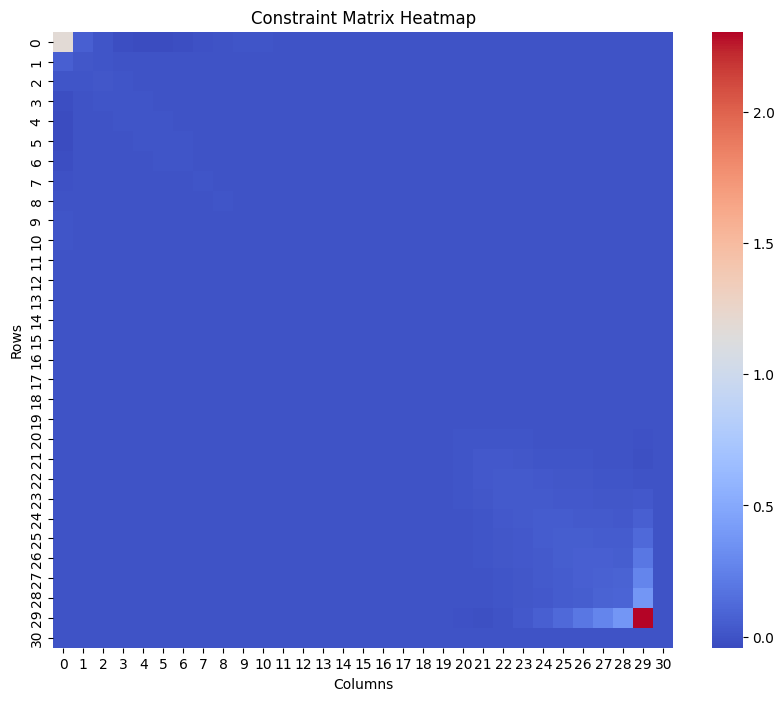

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the constraint matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cov, cmap="coolwarm", cbar=True)
plt.title("Constraint Matrix Heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

In [68]:
samplerr = TruncatedMVnGHKTiltedSampler2(mean,
                              cov+ np.eye(len(mean))*1e-3,
                              lower,
                              upper)

In [69]:
a = samplerr.sample(10)

[ 5.36069991e-03 -2.29585766e-03 -4.22646418e-04 -2.12178550e-03
 -4.07295132e-03  5.83770470e-03 -2.62547932e-03 -1.87455537e-03
 -1.86334493e-04  1.27537244e-03 -2.93588456e-06 -2.22901778e-03
  2.28926540e-03  1.87829859e-03 -7.67783920e-03  5.54427033e-03
  1.77460137e-03  1.24334122e-02  6.75558442e-03 -4.23460527e-03
  2.18849373e-03  6.06980268e-03  3.26077405e-03  1.31718605e-03
  3.59553000e-03 -5.13661291e-03  1.51833489e-03 -2.57551679e-03
  2.33383460e-03  5.54011321e-03  3.47906911e-03]
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan

In [67]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize

class TruncatedMVnGHKTiltedSampler2:
	def __init__(self, mu, Sigma, a, b):
		self.mu = np.asarray(mu)
		self.Sigma = np.asarray(Sigma)
		self.a = np.asarray(a)
		self.b = np.asarray(b)
		self.d = len(mu)

		assert self.Sigma.shape == (self.d, self.d), "Covariance matrix shape mismatch"
		assert self.a.shape == (self.d,) and self.b.shape == (self.d,), "Bounds shape mismatch"

		# Cholesky decomposition of covariance matrix
		self.L = np.linalg.cholesky(self.Sigma)

		# Transform bounds to standard normal space
		self.a_std = np.linalg.solve(self.L, self.a - self.mu)
		self.b_std = np.linalg.solve(self.L, self.b - self.mu)

	def grad_cgf(self, theta, num_samples=10000):
		z = np.random.randn(num_samples, self.d)
		weights = np.exp(z @ theta - 0.5 * np.sum(z**2, axis=1))
		return (weights[:, None] * z).mean(axis=0) / weights.mean()

	def hess_cgf(self, theta, num_samples=10000):
		z = np.random.randn(num_samples, self.d)
		weights = np.exp(z @ theta - 0.5 * np.sum(z**2, axis=1))
		Z_bar = (weights[:, None] * z).mean(axis=0) / weights.mean()
		ZZ_bar = (weights[:, None, None] * np.einsum('ni,nj->nij', z, z)).mean(axis=0) / weights.mean()
		return ZZ_bar - np.outer(Z_bar, Z_bar)

	def find_optimal_tilting(self):
		def objective(theta):
			grad = self.grad_cgf(theta)
			return 0.5 * np.dot(grad, grad)

		def grad_objective(theta):
			return self.hess_cgf(theta) @ self.grad_cgf(theta)

		theta0 = np.zeros(self.d)
		res = minimize(objective, theta0, jac=grad_objective, method='BFGS')
		return res.x

	def sample(self, n_samples=1):
		theta_star = self.find_optimal_tilting()
		print(theta_star)
		samples = []
		log_weights = []

		for _ in range(n_samples):
			z = np.zeros(self.d)
			log_weight = 0.0
			for i in range(self.d):
				Li = self.L[i, :i]
				mu_i = np.dot(Li, z[:i])
				std_i = self.L[i, i]

				lower = (self.a_std[i] - mu_i) / std_i
				upper = (self.b_std[i] - mu_i) / std_i

				theta_i = theta_star[i] * std_i
				alpha = norm.cdf(upper - theta_i) - norm.cdf(lower - theta_i)
				print(alpha)
				u = np.random.rand()
				quantile = norm.ppf(norm.cdf(lower - theta_i) + u * alpha)
				z_i = quantile + theta_i

				z[i] = mu_i + std_i * z_i
				log_weight += -theta_star[i] * z_i + 0.5 * theta_star[i]**2

			x = self.L @ z + self.mu
			samples.append(x)
			log_weights.append(log_weight)

		return np.array(samples) if n_samples > 1 else samples[0], np.exp(-np.array(log_weights))


In [82]:
cov

array([[ 1.17942739e+00,  6.20994600e-02,  3.57128687e-03,
        -2.99768773e-02, -4.24196044e-02, -3.95697609e-02,
        -2.59982217e-02, -1.05796713e-02,  1.71940235e-03,
         5.68080155e-03,  4.20162744e-03,  1.60738128e-04,
        -3.11782264e-04, -4.98879158e-04,  2.95130832e-04,
        -6.93145205e-05,  3.13376283e-05, -6.94795496e-05,
         1.71206762e-04, -2.46377769e-04,  1.54680411e-04,
        -8.28032496e-05,  6.76378234e-05, -9.16606887e-05,
         8.28915650e-05, -5.61625473e-05, -1.06412167e-05,
         3.48228307e-05,  3.32550867e-05,  3.78103183e-05,
         2.84319023e-05],
       [ 6.21176594e-02,  1.79067767e-02,  1.10624334e-02,
         2.78226537e-03, -2.59593593e-03, -4.55455441e-03,
        -4.46832568e-03, -2.61162480e-03, -7.58380693e-04,
         6.29248931e-04,  5.89365343e-04,  3.48549147e-04,
        -2.42796787e-04,  9.94397697e-05, -5.77019586e-05,
         3.15516094e-05, -1.82625647e-05,  2.80045356e-05,
        -6.37919884e-05,  9.42

In [95]:
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector
from rpy2.robjects import numpy2ri

# Enable NumPy <-> R auto-conversion
numpy2ri.activate()

# Import the tmvtnorm package
tmvtnorm = importr("tmvtnorm")

# Use your own pre-defined NumPy arrays:
# mean, cov, lower, upper must already be defined

# Wrap for R
mean_r = FloatVector(mean.tolist())
lower_r = FloatVector(lower.tolist())
upper_r = FloatVector(upper.tolist())

def to_r_matrix(array):
    return robjects.r.matrix(FloatVector(array.flatten('F')), nrow=array.shape[0])

mean = np.zeros(len(mean))
cov = np.eye(len(mean)) 
cov_r = to_r_matrix(cov+ np.eye(len(mean))*1e-6)

# Number of samples
n_samples = 5

# Call R function
samples_r = tmvtnorm.rtmvnorm(
    n=n_samples,
    mean=mean_r,
    sigma=cov_r,
    lower=lower_r,
    upper=upper_r
)

# Convert R output to NumPy
samples_np = np.array(samples_r).reshape((n_samples, len(mean)))


In [98]:
samples_np.shape

(5, 31)

Once we have calculated our approximate linear constraint, next step is to implement it based on finite differences for our constrained GP. Note that, we have picked the knots

\begin{equation}\nonumber
\mathbb{M} = \{\tilde{m}_1, \tilde{m}_2, \ldots, \tilde{m}_N \}
\end{equation}

where we define the functions value there as

\begin{equation}\nonumber
\xi_i = \tilde{f}(\tilde{m}_i)
\end{equation}


Then, we approximate the first derivative as:
* Interior points

\begin{equation} \nonumber
\tilde{f}'(\tilde{m}_i) \approx \frac{\xi_{i+1} - \xi_{i-1}}{2h}, \quad \text{for } 2 \leq i \leq N-1
\end{equation}


* Left boundary -- forward difference
\begin{equation} \nonumber
\tilde{f}'(\tilde{m}_1) \approx \frac{-3\xi_1 + 4 \xi_2 - \xi_3}{2h}
\end{equation}


* Right boundary -- backward difference
\begin{equation} \nonumber
\tilde{f}'(\tilde{m}_N) \approx \frac{\xi_{N-1} - 4 \xi_{N-2} + 3\xi_{N}}{2h}
\end{equation}


Similarly we approximate the second derivative as follows:

* Interior points

\begin{equation}\nonumber
\tilde{f}''(\tilde{m}_i) \approx \frac{\xi_{i+1} - 2\xi_i + \xi_{i-1}}{h^2}, \quad \text{for } 2 \leq i \leq N-1
\end{equation}

* Left boundary
\begin{equation}\nonumber
\tilde{f}''(\tilde{m}_1) \approx \frac{2\xi_1 - 5\xi_2  + 4\xi_3 -3 \xi_4}{h^3}
\end{equation}

* Right boundary
\begin{equation}\nonumber
\tilde{f}''(\tilde{m}_N) \approx \frac{-\xi_{N-3} + 4 \xi_{N-2}  -5 \xi_{N-1} + 2 \xi_{N}}{h^3}
\end{equation}




Thus we can rewrite our constraint after substituting for the finite difference approximations as:

* Interior points

\begin{equation} \nonumber
\small
\phi_i \cdot \frac{\xi_{i+1} - \xi_{i-1}}{2h}
+
\kappa \cdot \frac{\xi_{i+1} - 2\xi_i + \xi_{i-1}}{h^2}
\geq -1
\end{equation}

\begin{equation} \nonumber
\small
\left( -\frac{\phi_i}{2h} + \frac{\kappa}{h^2} \right) \xi_{i-1}
+
\left( -\frac{2\kappa}{h^2} \right) \xi_i
+
\left( \frac{\phi_i}{2h} + \frac{\kappa}{h^2} \right) \xi_{i+1}
\geq -1
\end{equation}

* Left boundary

\begin{equation} \nonumber
\small
\phi_1 \cdot \frac{-3\xi_1 + 4 \xi_2 - \xi_3}{2h}
+
\kappa \cdot \frac{2\xi_1 - 5\xi_2  + 4\xi_3 -3 \xi_4}{h^3}
\geq -1
\end{equation}

\begin{equation} \nonumber
\small
\left( \frac{2\kappa}{h^3} - \frac{3\phi_1}{2h} \right) \xi_1
+
\left( -\frac{5\kappa}{h^3} + \frac{4\phi_1}{2h} \right) \xi_2
+
\left( \frac{4\kappa}{h^3} - \frac{\phi_1}{2h} \right) \xi_3
+
\left( -\frac{3\kappa}{h^3} \right) \xi_4
\geq -1
\end{equation}


* Right boundary

\begin{equation} \nonumber
\small
\phi_N \cdot \frac{\xi_{N-1} - 4 \xi_{N-2} + 3\xi_{N}}{2h}
+
\kappa \cdot \frac{-\xi_{N-3} + 4 \xi_{N-2}  -5 \xi_{N-1} + 2 \xi_{N}}{h^3}
\geq -1
\end{equation}

\begin{equation} \nonumber
\small
\left( -\frac{\kappa}{h^3} \right) \xi_{N-3}
+
\left( \frac{4\kappa}{h^3} - \frac{4\phi_N}{2h} \right) \xi_{N-2}
+
\left( -\frac{5\kappa}{h^3} + \frac{\phi_N}{2h} \right) \xi_{N-1}
+
\left( \frac{2\kappa}{h^3} + \frac{3\phi_N}{2h} \right) \xi_N
\geq -1
\end{equation}





Finally, we express the discretized inequality constraint at each point $ \tilde{m}_i $ as a linear system:

$$
\Lambda \, \xi \geq -\mathbf{1}
$$

where:
- $ \xi = (\xi_1, \xi_2, \dots, \xi_N)^\top $ with $ \xi_i = \tilde{f}(\tilde{m}_i) $,
- $ \phi_i = \phi(\tilde{m}_i) $,
- $ \kappa $ is a constant,
- $ h $ is the uniform grid spacing.

The matrix $ \Lambda \in \mathbb{R}^{N \times N} $ is sparse. For interior rows $ i = 2, \dots, N-1 $, we use:

$$
\Lambda_{i, i-1} = -\frac{\phi_i}{2h} + \frac{\kappa}{h^2}, \quad
\Lambda_{i, i}   = -\frac{2\kappa}{h^2}, \quad
\Lambda_{i, i+1} = \frac{\phi_i}{2h} + \frac{\kappa}{h^2}
$$

At the boundaries, we apply one-sided finite differences:

- Left boundary ($ i = 1 $):

$$
\Lambda_{1,1} = \frac{2\kappa}{h^3} - \frac{3\phi_1}{2h}, \quad
\Lambda_{1,2} = -\frac{5\kappa}{h^3} + \frac{4\phi_1}{2h}, \quad
\Lambda_{1,3} = -\frac{4\kappa}{h^3} - \frac{\phi_1}{2h}, \quad
\Lambda_{1,4} =  -\frac{3\kappa}{h^3}
$$

- Right boundary ($ i = N $):

$$
\Lambda{N,N-3} = -\frac{\kappa}{h^3}, \quad
\Lambda_{N,N-2} = \frac{4\kappa}{h^3} - \frac{4\phi_N}{2h}, \quad
\Lambda_{N,N-1} =  -\frac{5\kappa}{h^3} + \frac{\phi_N}{2h}, \quad
\Lambda_{N,N}   =  \frac{2\kappa}{h^3} + \frac{3\phi_N}{2h}
$$

The first few rows of $ \Lambda $ follow this pattern:

$$
\Lambda =
\begin{bmatrix}
\frac{2\kappa}{h^3} - \frac{3\phi_1}{2h} & -\frac{5\kappa}{h^3} + \frac{4\phi_1}{2h} & -\frac{4\kappa}{h^3} - \frac{\phi_1}{2h} &  -\frac{3\kappa}{h^3} & \cdots \\
\ast & \ast & \ast & \cdots & 0 \\
\vdots & \ddots & \ddots & \ddots & \vdots \\
0 & \frac{4\kappa}{h^3} - \frac{4\phi_N}{2h} & -\frac{5\kappa}{h^3} + \frac{\phi_N}{2h} & \frac{2\kappa}{h^3} + \frac{3\phi_N}{2h}
\end{bmatrix}
$$


In [ ]:
import numpy as np

def build_constraint_matrix(N, h, phi, kappa):
	"""
	Construct the NxN matrix Lambda such that Lambda @ xi >= -1
	where xi = [f(m_1), ..., f(m_N)] and
	the inequality is: phi_i * f'(m_i) + kappa * f''(m_i) >= -1

	Parameters:
		N     : int        -- number of grid points
		h     : float      -- grid spacing (uniform)
		phi   : ndarray    -- shape (N,), values of phi_i at each point
		kappa : float      -- fixed scalar multiplier of second derivative

	Returns:
		Lambda : ndarray of shape (N, N)
		b      : ndarray of shape (N,), equal to -1
	"""
	Lambda = np.zeros((N, N))
	b = -np.ones(N)

	for i in range(N):
		if i == 0:
			# Left boundary
			Lambda[i, 0] = 2 * kappa / h**3 - 3 * phi[i] / (2*h)
			Lambda[i, 1] =  -5 * kappa / h**3 + 4 * phi[i] / (2*h)
			Lambda[i, 2] = 4 * kappa / h**3 - 1 * phi[i] / (2*h)
			Lambda[i, 3] = -3 * kappa / h**3 

		elif i == N - 1:
			# Right boundary
			Lambda[i, N-4] = -1 * kappa / h**3
			Lambda[i, N-3] = 4 * kappa / h** - 4* phi[i] / (2*h)
			Lambda[i, N-2] =  -5 * kappa / h**3 + phi[i] / (2*h)
			Lambda[i, N-1] = 2 * kappa / h**3 + 3 * phi[i] / (2*h)

		else:
			# Interior points
			Lambda[i, i-1] = -phi[i] / (2*h) + kappa / h**2
			Lambda[i, i]   = -2 * kappa / h**2
			Lambda[i, i+1] =  phi[i] / (2*h) + kappa / h**2

	return Lambda, b